In [6]:
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import math

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option('display.width', 10000)

# Change the project name here to your project name in your account
client = bigquery.Client(project="dsa3101-435110")  # Brandon
# client = bigquery.Client(project="dsa3101-434713")  # Swislar
# client = bigquery.Client(project="sturdy-cable-435110-g9") # Yan Rong

In [9]:

# Data cleaning function for categories
def clean_categories(googleAnalytics_df: pd.DataFrame):
    """
    Cleans category based on product.v2ProductCategory AS 'Category' 
    and product.v2ProductName AS 'product_name'
    """
    # Pandas
    googleAnalytics_df['Category'].replace(
        ['(not set)', '${productitem.product.origCatName}'], np.nan, inplace=True)

    # Regex - Category
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"escCatTitle", case=False, na=False), "Category"] = np.nan
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"Accessories", case=True, na=False), "Category"] = "Accessories"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"(Apparel|Wearables|Outerwear)", case=True, na=False), "Category"] = "Apparel"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"Bags", case=True, na=False), "Category"] = "Bags"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"(Drinkware|Bottle|Mugs)", case=True, na=False), "Category"] = "Drinkware"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"Fun", case=True, na=False), "Category"] = "Fun"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"Gift Cards", case=True, na=False), "Category"] = "Gift Cards"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"Electronics", case=True, na=False), "Category"] = "Electronics"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"(Office|Writing|Notebooks & Journals)", case=True, na=False), "Category"] = "Office"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"(Brand|YouTube|Waze)", case=True, na=False), "Category"] = "Brands"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"(Lifestyle|YouTube)", case=True, na=False), "Category"] = "Lifestyle"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"(Limited|Clearance|Sale)", case=True, na=False), "Category"] = "Sale"
    googleAnalytics_df.loc[googleAnalytics_df["Category"].str.contains(
        r"Kids", case=True, na=False), "Category"] = "Kids"

    # Regex - product_name
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Waze.*(Men's|Women's|Socks)", case=True, na=False), "Category"] = "Apparel"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"(Shirt|Sleeve|Tee|Jacket|Pullover|Hoodie|Tank|Vest|Onesie|Pants|Hood|Polo)", case=True, na=False), "Category"] = "Apparel"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"(oz|Bottle|Cup)", case=True, na=False), "Category"] = "Drinkware"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Journal|Notebook", case=True, na=False), "Category"] = "Office"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Bag|Backpack|Tote|Rucksack", case=True, na=False), "Category"] = "Bags"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Gift Card", case=True, na=False), "Category"] = "Gift Cards"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Electronic|Device|Headphones|Earbuds|Earphones", case=True, na=False), "Category"] = "Electronics"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Cap|Hat", case=True, na=False), "Category"] = "Apparel"
    googleAnalytics_df.loc[googleAnalytics_df["product_name"].str.contains(
        r"Pen", case=True, na=False), "Category"] = "Office"
    return googleAnalytics_df

# Q1


What are the key factors influencing customer purchasing behavior?

- Analyze historical sales data to identify patterns and trends.
- Develop customer segmentation models based on purchasing behavior.


### Visitor browsing patterns


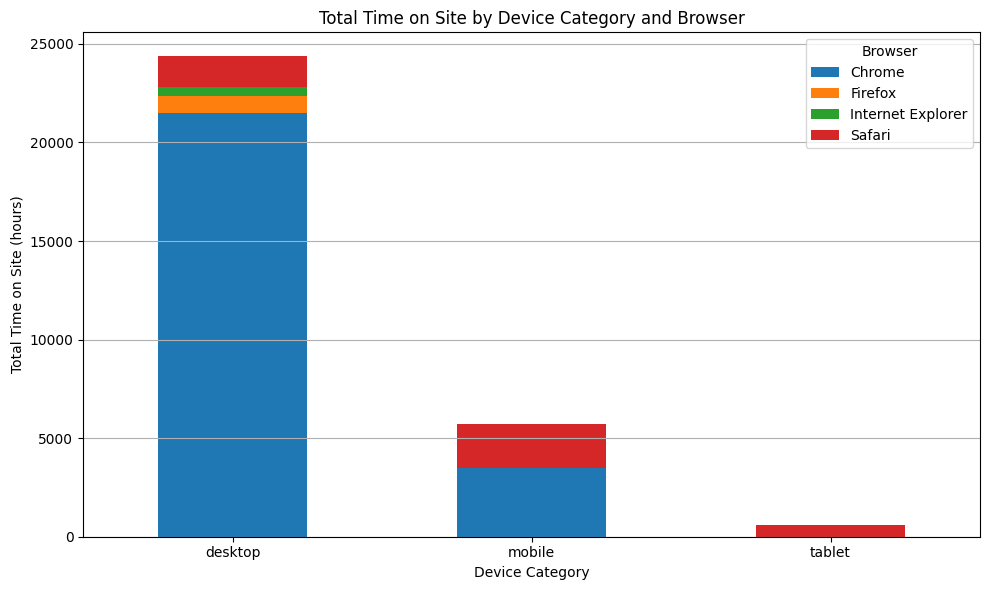

In [37]:
query = """
        SELECT
            device.operatingSystem AS OperatingSystem,
            device.deviceCategory AS DeviceCategory,
            device.browser AS Browser,
            SUM(totals.timeOnSite)/3600 AS TotalTimeOnSite,
            COUNT(*) AS VisitCount
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        GROUP BY
            OperatingSystem,
            DeviceCategory,
            Browser
        ORDER BY
            TotalTimeOnSite DESC
        LIMIT 10
        """
rows = client.query(query)

result_df = rows.to_dataframe()

grouped = result_df.groupby(['DeviceCategory', 'Browser']).agg(
    {'TotalTimeOnSite': 'sum', 'VisitCount': 'sum'}).unstack(fill_value=0)

grouped['TotalTimeOnSite'].plot(kind='bar', stacked=True, figsize=(10, 6))

plt.title('Total Time on Site by Device Category and Browser')
plt.xlabel('Device Category')
plt.ylabel('Total Time on Site (hours)')
plt.xticks(rotation=0)
plt.legend(title='Browser')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Since a large proportion of traffic to the website comes from either desktop or mobile devices, with the primary browsers being either Chrome, the website's compatibility with these browsers and devices must be ensured to provide a smooth browsing experience for visitors.


### Type of purchases and revenue by month


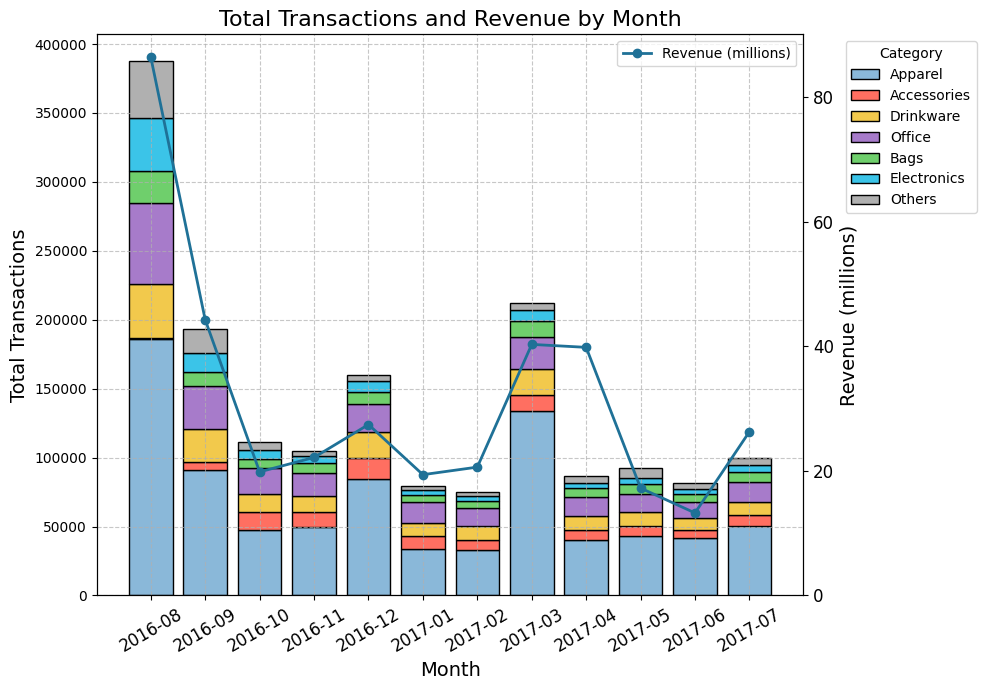

In [120]:
query = """
        SELECT FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS MONTH, product.v2ProductCategory AS Category, product.v2ProductName AS product_name, SUM(totals.transactions) AS TotalTransactions, SUM(totals.totalTransactionRevenue)/1e6 AS TotalRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits, UNNEST(hits.product) AS product
        GROUP BY MONTH, Category, product_name
        HAVING TotalTransactions > 0
        ORDER BY MONTH, Category
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Clean categories
result_df = clean_categories(result_df)

# Extract the top 6 categories
top_categories = result_df.groupby(
    'Category')['TotalTransactions'].sum().nlargest(6).index

# Create a new column for categories
result_df['Category'] = result_df['Category'].apply(
    lambda x: x if x in top_categories else 'Others'
)

# Since '2017-08' only contains 1 day of data
result_df = result_df.query("MONTH < '2017-08'")

# Pivot the DataFrame to wide format
pivot_df = result_df.pivot_table(
    index='MONTH', columns='Category', values=['TotalTransactions', 'TotalRevenue'], aggfunc='sum', fill_value=0)


# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(10, 7))

# Initialize the bottom parameter
bottoms = [0] * len(pivot_df)

category_colors = {
    'Apparel': '#8AB8D9',  # Soft Blue
    'Accessories': '#FF6F61',  # Vivid Coral
    'Drinkware': '#F2C94C',  # Bright Yellow
    'Office': '#A77BCA',   # Soft Purple
    'Bags': '#6FCF6C',  # Bright Green
    "Electronics": '#3BC4E8',   # Vivid Cyan
    'Others': '#B0B0B0'  # Medium Gray
}

# Plot the stacked bar chart on the primary y-axis
for category, color in category_colors.items():
    if category in pivot_df.TotalTransactions.columns:
        ax1.bar(pivot_df.index, pivot_df.TotalTransactions[category], bottom=bottoms,
                label=category, color=color, edgecolor='black')
        bottoms = [bottoms[j] + pivot_df.TotalTransactions[category].iloc[j]
                   for j in range(len(bottoms))]

# Create a secondary y-axis
ax2 = ax1.twinx()
ax2.plot(pivot_df.index, pivot_df.TotalRevenue.sum(axis=1)/1e6, marker='o',
         color='#1F7197', linestyle='-', linewidth=2, label='Revenue (millions)')

ax1.set_xlabel('Month', fontsize=14)
ax1.set_ylabel('Total Transactions', fontsize=14)
ax1.set_title('Total Transactions and Revenue by Month', fontsize=16)
ax1.tick_params(axis='x', rotation=30, labelsize=12)
ax1.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

ax2.set_ylabel('Revenue (millions)', fontsize=14)
ax2.tick_params(axis='y', labelsize=12)
ax2.legend(loc='upper right')
ax2.set_ylim(bottom=0)

ax1.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

2016-08: Large number of transactions accross all categories.

2017-03: Large increase of transactions in the apparel category.

A sharp spike in transaction and revenue in certain months could suggest that promotions/advertisement method is effective for that month.


### Exit and Bounce rates


<strong>Exit rate</strong> is the percentage of users who leave a site from a specific page after visiting multiple pages.

It measures how many users exit from a particular page compared to the total number of page views for that page.

A high exit rate on a specific page may indicate issues with that page or that users are not finding what they need and leaving.


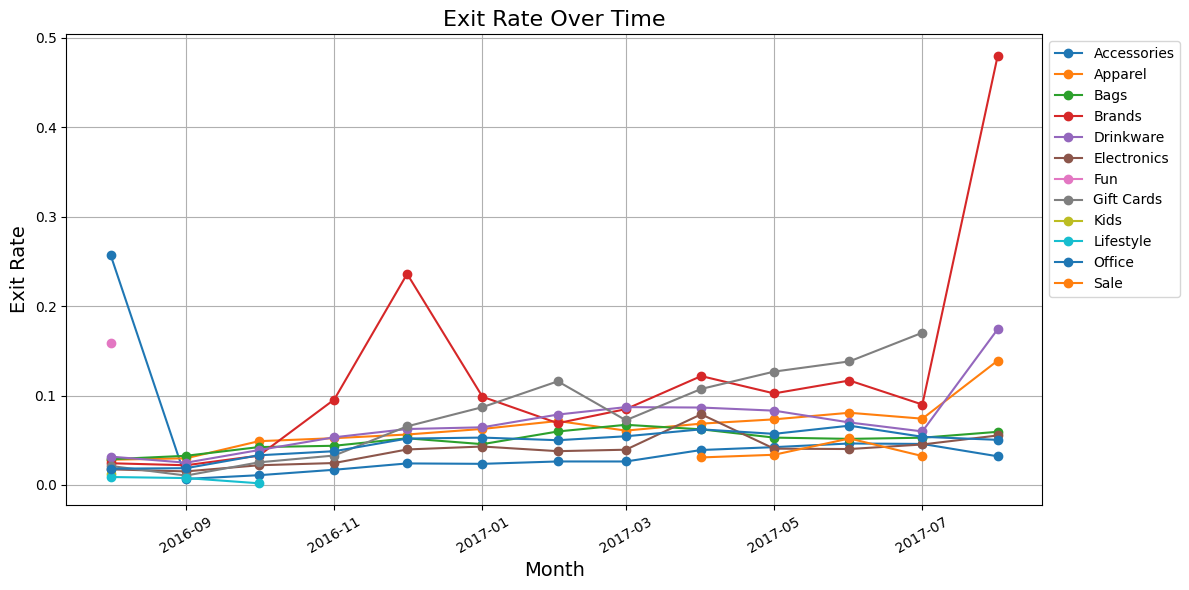

In [145]:
# Exit rate by pages
query = f"""
        SELECT FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS MONTH, product.v2ProductCategory AS Category, product.v2ProductName AS product_name, COUNT(*) AS Views, SUM(totals.bounces)/COUNT(*) AS ExitRate
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits, UNNEST(hits.product) AS product
        WHERE hits.type='PAGE'
        GROUP BY MONTH, Category, product_name
        -- Filter out for records with bounces and only keep those with a significant number of views
        HAVING SUM(totals.bounces) > 0 AND Views >= 100
        """

rows = client.query(query)

result_df = rows.to_dataframe()

result_df_exit = clean_categories(result_df)

exit_rate_df = result_df_exit.groupby(["Category", "MONTH"]).mean(
    "ExitRate").drop(columns=["Views"]).reset_index()

# Convert 'MONTH' to datetime
exit_rate_df['MONTH'] = pd.to_datetime(exit_rate_df['MONTH'])

plt.figure(figsize=(12, 6))

# Plot ExitRate for each category
for category in exit_rate_df['Category'].unique():
    subset_exit = exit_rate_df[exit_rate_df['Category'] == category]
    plt.plot(subset_exit['MONTH'], subset_exit['ExitRate'],
             marker='o', linestyle='-', label=f'{category}')

plt.title('Exit Rate Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Exit Rate', fontsize=14)
plt.xticks(rotation=30)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.grid()
plt.tight_layout()

plt.show()

Exit rates are gradually rising overtime for Brands, Gift Cards, Drink and Sale products while the rest remains relatively constant.

Brands have seen a sharp increase in exit rates in 12-2016 and 08-2017. This could suggest that some changes made to the products in the Brands category is unappealing, causing visitors to exit.


<strong>Bounce rate</strong> is the percentage of visitors who navigate away from a website after viewing only one page.

It indicates how effectively a website engages its visitors.

A high bounce rate may suggest that the landing page is not relevant to the audience or that users did not find what they were looking for.


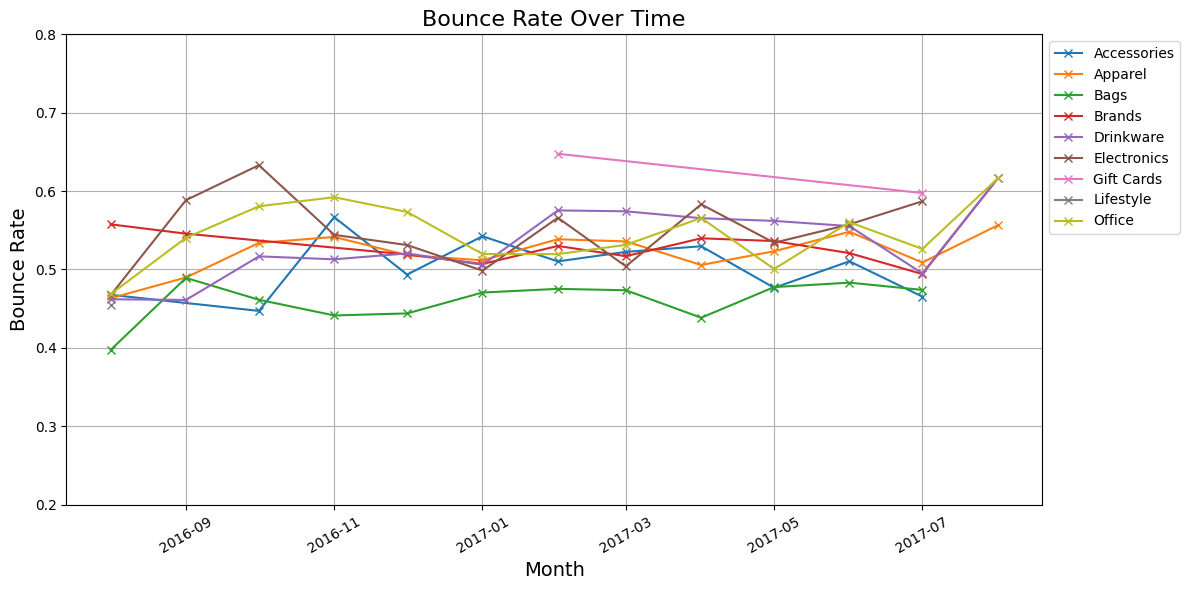

In [148]:
query = f"""
        SELECT FORMAT_DATE('%Y-%m', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS MONTH, product.v2ProductCategory AS Category, product.v2ProductName AS product_name, COUNT(*) AS Views, SUM(totals.bounces)/COUNT(*) AS BounceRate
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) as hits, UNNEST(hits.product) AS product
        WHERE hits.type = 'PAGE' AND hits.hitNumber = 1
        GROUP BY MONTH, Category, product_name
        -- Filter out for records with bounces and only keep those with a significant number of views
        HAVING SUM(totals.bounces) > 0 AND Views >= 100
        """
rows = client.query(query)

result_df = rows.to_dataframe()

result_df_bounce = clean_categories(result_df)


bounce_rate_df = result_df_bounce.groupby(["Category", "MONTH"]).mean(
    "BounceRate").drop(columns=["Views"]).reset_index()

# Convert 'MONTH' to datetime
bounce_rate_df['MONTH'] = pd.to_datetime(bounce_rate_df['MONTH'])

# Plotting Bounce Rate
plt.figure(figsize=(12, 6))

# Plot BounceRate for each category
for category in bounce_rate_df['Category'].unique():
    subset_bounce = bounce_rate_df[bounce_rate_df['Category'] == category]
    plt.plot(subset_bounce['MONTH'], subset_bounce['BounceRate'],
             marker='x', linestyle='-', label=f'{category}')

plt.title('Bounce Rate Over Time', fontsize=16)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Bounce Rate', fontsize=14)
plt.xticks(rotation=30)
plt.ylim(0.2, 0.8)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
plt.grid()
plt.tight_layout()

plt.show()

Unlike exit rates, bounce rates have remained relatively constant throughout the year which means nothing much has changed in terms of customer behaviour.


### Correlation between transactions, page views, time on site and revenue


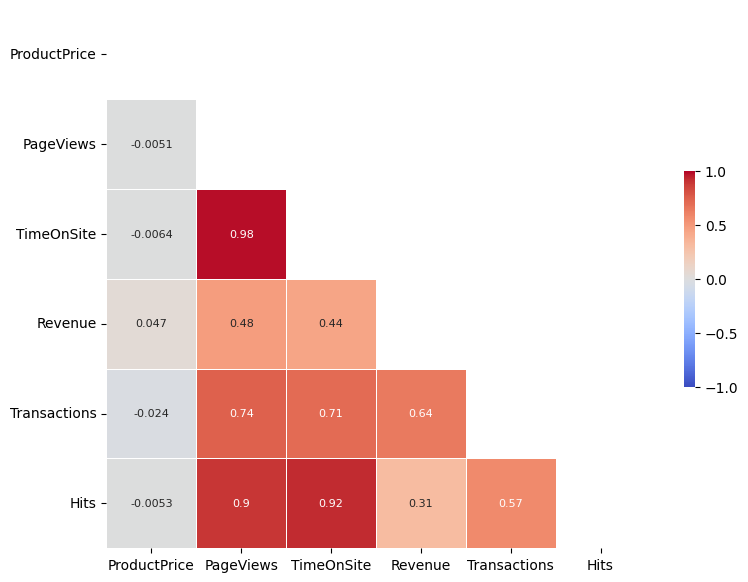

In [5]:
query = f"""
        SELECT channelGrouping AS ChannelGrouping, device.browser AS Browser, geoNetwork.country AS Country, prod.productListPosition AS ProductListPosition, hits.page.pagePath AS PagePath, prod.v2ProductCategory AS ProductCategory,  trafficSource.source AS TrafficSource, prod.productPrice AS ProductPrice, prod.productListName AS ProductListName, hits.promotionActionInfo.promoIsView AS PromoIsView, hits.promotionActionInfo.promoIsClick AS PromoIsClick,
        SUM(totals.pageviews) AS PageViews,  SUM(totals.timeOnSite) AS TimeOnSite, SUM(totals.totalTransactionRevenue)/1000000 AS Revenue, SUM(totals.transactions) AS Transactions, COUNT(totals.hits) AS Hits
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) as hits, UNNEST(hits.product) as prod
        GROUP BY 1,2,3,4,5,6,7,8,9,10,11
        """

rows = client.query(query)

result_df = rows.to_dataframe()

corr_matrix = result_df[['ProductPrice', 'PageViews',
                         'TimeOnSite', 'Revenue', 'Transactions', 'Hits']].corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 7))
heatmap = sns.heatmap(corr_matrix,
                      square=True,
                      mask=mask,
                      linewidths=.5,
                      cmap='coolwarm',
                      cbar_kws={'shrink': .4, 'ticks': [-1, -.5, 0, 0.5, 1]},
                      vmin=-1,
                      vmax=1,
                      annot=True,
                      annot_kws={'size': 8})
ax.set_yticklabels(corr_matrix.columns, rotation=0)
ax.set_xticklabels(corr_matrix.columns)
sns.set_style({'xtick.bottom': True}, {'ytick.left': True})

Page views and time spent on the site positively correlate with the number of transactions.

By increasing customer engagement on the site, we could potentially boost the number of transactions and revenue.


### Visualisation of Customer Recency


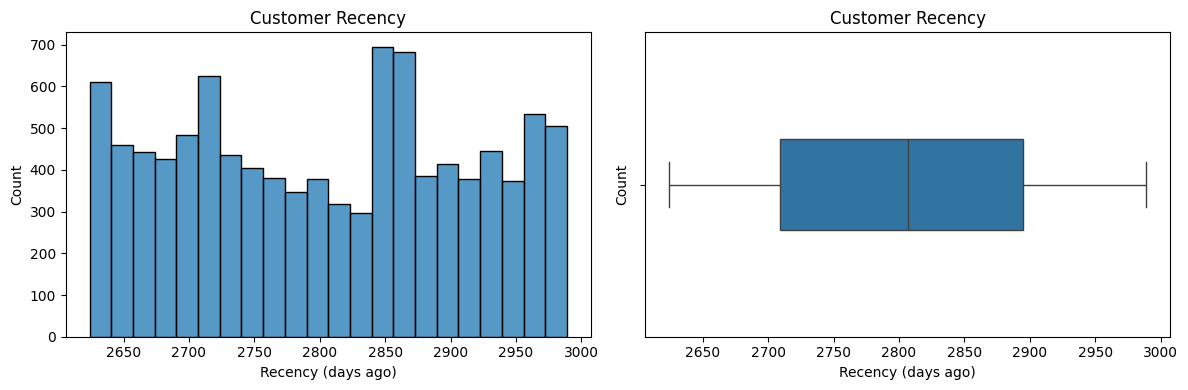

In [14]:
query = f"""
    WITH CustomerRecency AS (
        SELECT
            fullVisitorId AS visitorId,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE totals.transactions >= 1
    )

    -- Number of days between the current date and the date of last purchase
    SELECT
        visitorId,
        DATE_DIFF(CURRENT_DATE(), MAX(date), DAY) AS recency
    FROM
        CustomerRecency
    GROUP BY
        visitorId
    """
rows = client.query(query)

result_df = rows.to_dataframe()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(result_df.recency, ax=axes[0])
axes[0].set_title('Customer Recency')
axes[0].set_xlabel('Recency (days ago)')
axes[0].set_ylabel('Count')

sns.boxplot(x=result_df.recency, ax=axes[1], width=0.3)
axes[1].set_title('Customer Recency')
axes[1].set_xlabel('Recency (days ago)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

The box plot of customer recency shows no outliers, indicating that the inflow of customers who made transactions on the site is generally consistent throughout the year.


### Visualisation of Customer Frequency


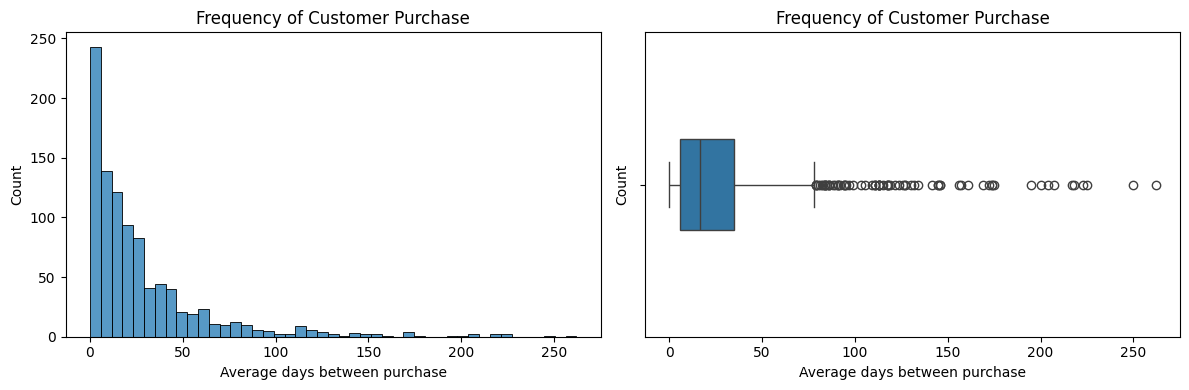

In [13]:
query = f"""
    WITH CustomerFrequency AS (
        SELECT
            fullVisitorId AS visitorId,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
            COALESCE(totals.transactions, 0) AS transactions,
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE totals.transactions > 0
    ),
    -- Get the date the current purchase and the date of the previous purchase for each customer
    LaggedCustomerFrequency AS (
        SELECT
            LAG(date, 1)
            OVER (PARTITION BY
                    visitorId
                ORDER BY
                    date
                )
            AS previousDate,
            visitorId,
            date
        FROM
            CustomerFrequency
    ),
    -- Number of days between each transaction for each customer
    frequencyData AS (
        SELECT
            visitorId,
            DATE_DIFF(LaggedCustomerFrequency.date, LaggedCustomerFrequency.previousDate, DAY) AS diffDays
        FROM
            LaggedCustomerFrequency
        WHERE
            LaggedCustomerFrequency.previousDate IS NOT NULL
    )

    SELECT
        visitorId,
        AVG(diffDays) AS frequency
    FROM
        frequencyData
    GROUP BY
        visitorId
    """
rows = client.query(query)

result_df = rows.to_dataframe()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(result_df.frequency, ax=axes[0])
axes[0].set_title('Frequency of Customer Purchase')
axes[0].set_xlabel('Average days between purchase')
axes[0].set_ylabel('Count')

sns.boxplot(x=result_df.frequency, ax=axes[1], width=0.3)
axes[1].set_title('Frequency of Customer Purchase')
axes[1].set_xlabel('Average days between purchase')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

The frequency of customer purchases is generally low, with a number of high frequency outliers.

This could indicate that the product is:

- Durable which leads to less frequent repurchases
- Of a poor quality as products are not meeting the customer expectations, leading to a lack of repeat purchase


### Visualisation of Customer Monetary


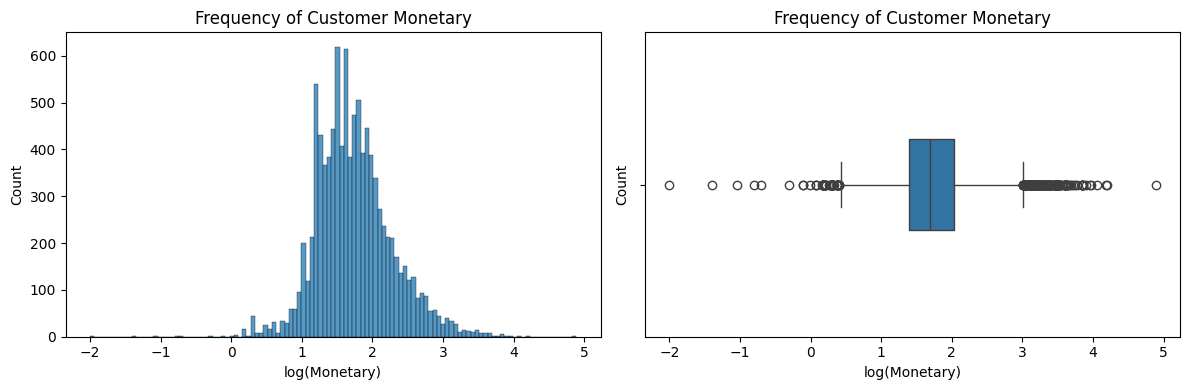

In [6]:
query = f"""
    WITH CustomerMonetary AS (
        SELECT
            fullVisitorId AS visitorId,
            COALESCE(totals.transactionRevenue, 0) AS transactionRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE totals.transactions >= 1
    )

    SELECT
        visitorId,
        SUM(transactionRevenue)/1e6 AS monetary
    FROM
        CustomerMonetary
    GROUP BY
        visitorId
    """
rows = client.query(query)

result_df = rows.to_dataframe()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sns.histplot(np.log10(result_df.monetary), ax=axes[0])
axes[0].set_title('Frequency of Customer Monetary')
axes[0].set_xlabel('log(Monetary)')
axes[0].set_ylabel('Count')

sns.boxplot(x=np.log10(result_df.monetary), ax=axes[1], width=0.3)
axes[1].set_title('Frequency of Customer Monetary')
axes[1].set_xlabel('log(Monetary)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

The customer spending data is right-skewed, indicating that most customers spend relatively little, while a few spend significantly more.

After applying a logarithmic transformation, the box plot shows outliers on both the left and right sides, indicating that while there are customers with very low spending, there are also very high spenders.

This could imply a diverse customer base with varying spending behaviors, which may warrant targeted marketing strategies to engage both low and high spenders effectively.


### Customer segmentation model


#### Customers by Country (Top 10)


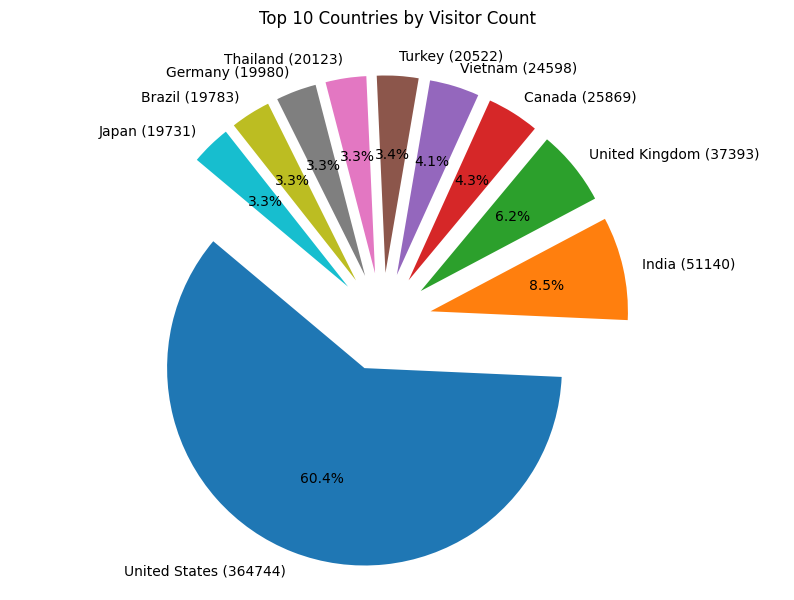

In [ ]:
query = """
    SELECT
        geoNetwork.country AS Country,
        SUM(totals.visits) AS VisitorCount
    FROM
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    GROUP BY
        geoNetwork.country
    ORDER BY
        VisitorCount DESC
    LIMIT 10
    """
rows = client.query(query)

result_df = rows.to_dataframe()

labels = result_df['Country'] + \
    ' (' + result_df['VisitorCount'].astype(str) + ')'
sizes = result_df['VisitorCount']

plt.figure(figsize=(10, 7))

explode = [0.1] * len(sizes)

wedges, texts, autotexts = plt.pie(sizes, labels=labels, autopct='%1.1f%%',
                                   startangle=140, radius=0.4, explode=explode)

plt.title('Top 10 Countries by Visitor Count', pad=20)
plt.axis('equal')

for i, wedge in enumerate(wedges):
    angle = (wedge.theta2 + wedge.theta1) / 2
    x_text = 1.1 * np.cos(np.radians(angle))
    y_text = 1.1 * np.sin(np.radians(angle))
    plt.annotate('', xy=(x_text, y_text), xytext=(0, 0),
                 arrowprops=dict(arrowstyle='->', color='black'))

plt.show()

#### RFM (Recency, Frequency, Monetary)


RFM (Recency, Frequency, Monetary) analysis is used to segment the customers before running behaviour-based clustering algorithm () to automatically find customer groups


In [32]:
query = f"""
    -- Selecting the neccessary columns for RMF analysis
    WITH RFMData AS (
        SELECT
            visitNumber,
            fullVisitorId AS visitorId,
            CAST(SUBSTRING(date, 1, 4) || '-' || SUBSTRING(date, 5, 2) || '-' || SUBSTRING(date, 7, 2) AS DATE) AS date,
            COALESCE(totals.transactions, 0) AS transactions,
            COALESCE(totals.transactionRevenue, 0) AS transactionRevenue
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        WHERE
            date != "None"
        ORDER BY
            visitorID,
            visitNumber
    ),
    -- Calculate recency score by calculating the number of days since last purchase
    recencyScore AS (
        SELECT
            visitorId,
            DATE_DIFF(CURRENT_DATE(), MAX(date), DAY) AS recency
        FROM
            RFMData
        GROUP BY
            visitorId
    ),
    -- Creating a new column of the next purchase date by taking date from next row for the customer
    leadData AS (
        SELECT
            LEAD(date, 1)
            OVER (PARTITION BY
                    visitorId
                ORDER BY
                    visitorId,
                    visitNumber
                )
            AS nextDate,
            visitorId,
            visitNumber,
            transactions,
            date
        FROM
            RFMData
    ),
    -- Set next day to be null when for the latest transaction
    fixedLeadData AS (
        SELECT
            COALESCE(nextDate, CURRENT_DATE()) AS nextDate,
            visitorId,
            visitNumber,
            transactions,
            date
        FROM
            leadData
    ),
    -- Calculate the number of days between data and next date columns
    frequencyData AS (
        SELECT
            RFMData.visitorId,
            DATE_DIFF(lead.date, lead.nextDate, DAY) AS diffDays
        FROM
            RFMData
        INNER JOIN
            fixedLeadData lead
        ON
            RFMData.visitorId = lead.visitorId AND RFMData.visitNumber = lead.visitNumber
    ),
    -- Calculate the average number of days inbetween purchases
    frequencyScore AS (
        SELECT
            visitorId,
            AVG(diffDays) AS frequency
        FROM
            frequencyData
        GROUP BY
            visitorId
    ),
    -- Calculate the total transaction every customer spent
    monetaryScore AS (
        SELECT
            visitorId,
            SUM(transactionRevenue) AS monetary
        FROM
            RFMData
        GROUP BY
            visitorId
    ),
    -- Combining all the score tables into one table
    rmftable AS (
        SELECT
           r.visitorId,
           r.recency,
           f.frequency,
           m.monetary,
        FROM
            recencyScore AS r
        JOIN
            frequencyScore AS f
        ON
            r.visitorId = f.visitorId
        JOIN
            monetaryScore AS m
        ON
            m.visitorId = r.visitorId
    ),
    -- Split each score into 4 quartiles as bins
    rmfScore AS (
        SELECT
            visitorId,
            NTILE(4) OVER (ORDER BY recency ASC) AS recency_score,
            NTILE(4) OVER (ORDER BY frequency DESC) AS frequency_score,
            NTILE(4) OVER (ORDER BY monetary DESC) AS monetary_score,
        FROM
            rmftable
    )

    -- Calculate the total score by summing all the inidividual scores
    SELECT
        visitorId,
        (recency_score + frequency_score + monetary_score) AS totalScore,
        recency_score AS recencyScore, frequency_score AS frequencyScore, monetary_score AS monetaryScore
    FROM
        rmfScore
    """
rows = client.query(query)

result_df = rows.to_dataframe()

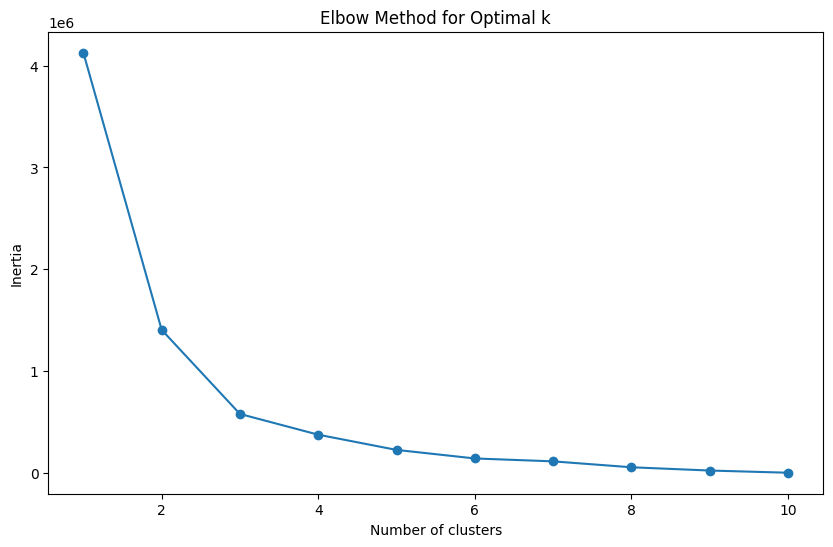

In [33]:
inertia = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(result_df["totalScore"].to_frame())
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [34]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
result_df['cluster'] = kmeans.fit_predict(result_df["totalScore"].to_frame())

In [43]:
# Summary of clusters
cluster_summary = result_df.groupby('cluster').agg({
    'recencyScore': ['min', 'max'],
    'frequencyScore': ['min', 'max'],
    'monetaryScore': ['min', 'max'],
    'visitorId': 'count'
})

cluster_summary

recencyScore     frequencyScore     monetaryScore     visitorId
                 min max            min max           min max     count
cluster                                                                
0                  1   4              1   4             1   4    284461
1                  1   4              1   3             1   4    263989
2                  3   4              3   4             2   4    165717

Cluster 0: Large and diverse, with varied recency and spending behaviors; important for general marketing.

Cluster 1: Slightly smaller, less frequent visitors; potential for re-engagement strategies.

Cluster 2: Highly engaged and valuable visitors with recent activity; ideal for loyalty and premium offers.


# Q2


How can we improve customer retention and lifetime value?

- Calculate customer churn rates and identify at-risk customers.
- Analyze the effectiveness of current retention strategies.


### Calculating customer churn rates using Customer Count


Here, we define churn rates as the percentage change of customers on the platform who made at least 1 purchase.

It is also the percentage of customers who stop using a service within a specific time period.

A high churn rate can indicate customer dissatisfaction or increased competition, while a low churn rate suggests better customer retention.


In [96]:
# https://www.salesforce.com/sales/analytics/customer-churn/#calculate
# https://whatfix.com/blog/retention-analysis/
def churn_rate():
    query = """
            WITH InitialActiveCustomers AS (
                -- All the VisitorID in the FY
                SELECT
                    PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                    fullVisitorID
                FROM
                    `bigquery-public-data.google_analytics_sample.ga_sessions_*`
                WHERE
                    _TABLE_SUFFIX BETWEEN '20160801' AND '20170731' AND totals.transactions > 0
                GROUP BY
                    Date, fullVisitorID
            ),

            MonthlyCustomers AS (
                SELECT
                    EXTRACT(YEAR FROM Date) AS Year,
                    EXTRACT(MONTH FROM Date) AS Month,
                    fullVisitorID
                FROM InitialActiveCustomers
                GROUP BY Year, Month, fullVisitorID
            ),

            MonthlyStats AS (
                -- Number of unique customers per month
                SELECT
                    Year,
                    Month,
                    COUNT(DISTINCT fullVisitorID) AS TotalCustomers
                FROM MonthlyCustomers
                GROUP BY Year, Month
            ),

            ChurnData AS (
                -- Compute Month Over Month churn rates
                SELECT
                    a.Year,
                    a.Month,
                    COALESCE(b.TotalCustomers, 0) AS PreviousMonthCustomers,
                    a.TotalCustomers AS CurrentMonthCustomers,
                    (COALESCE(b.TotalCustomers, 0) - a.TotalCustomers) AS ChurnedCustomers
                FROM MonthlyStats a
                LEFT JOIN MonthlyStats b
                    ON (a.Year = b.Year AND a.Month = b.Month + 1)
                    OR (a.Year = b.Year + 1 AND a.Month = 1 AND b.Month = 12)  -- Handle year transition
                ORDER BY Year, Month
            )

            SELECT
                Year,
                Month,
                PreviousMonthCustomers,
                CurrentMonthCustomers,
                ChurnedCustomers,
                (ChurnedCustomers / NULLIF(PreviousMonthCustomers, 0)) * 100 AS ChurnRate
            FROM ChurnData
            WHERE PreviousMonthCustomers > 0  -- Exclude first month with no previous data
            ORDER BY Year, Month;
            """
    return query

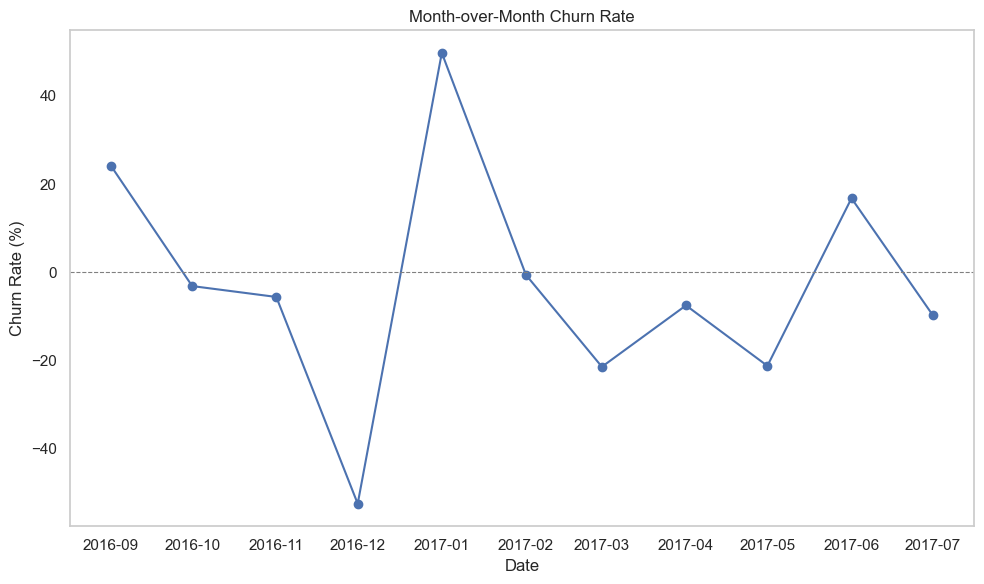

In [97]:
query = churn_rate()

rows = client.query(query)

result_df = rows.to_dataframe()

result_df['Date'] = pd.to_datetime(result_df[['Year', 'Month']].assign(DAY=1))

plt.figure(figsize=(10, 6))
plt.plot(result_df['Date'], result_df['ChurnRate'],
         marker='o', linestyle='-', color='b')
plt.title('Month-over-Month Churn Rate')
plt.xlabel('Date')
plt.ylabel('Churn Rate (%)')
plt.grid()
plt.xticks(result_df['Date'],
           result_df['Date'].dt.strftime('%Y-%m'))
plt.axhline(0, color='grey', lw=0.8, ls='--')
plt.tight_layout()
plt.show()

### Identifying at risk customers using Moving Averages


Using the entire dataset of a year, the factors used to identify at risk customers using different time periods:

- Main moving average, Days (MainMA)
- Standard deviation moving average, Days (StdMA)
- Lag of lower bound, Days (LowerBound = MainMA - StdMA)
- Grace period before being marked as a churner


Here, we computed it by:

- Aggregating each customer's transaction based on a moving average (MainMA)
- Calculating the stardard deviation of each customer's transaction based on another moving average (StdMa)
- Determining the lower bound for which the customer has churned and lag it

When the moving average (MainMA) goes below the lagged lower bound, the customer is identified as a churner.

An at risk customer is have a moving average (MainMA) below the lagged lower bound but is still within the grace period.


In [236]:
# https://medium.com/octave-john-keells-group/a-simple-six-step-approach-to-define-customer-churn-in-retail-f401e31e57c0#:~:text=Identifying%20the%20point%20in%20which,time%20to%20proactively%20implement%20interventions.&text=Step%206%3A,is%20identified%20as%20a%20churner.
def churn_rate_MA(moving_average_main: int = 30, moving_average_std: int = 90, lower_bound_lag: int = 30):
    query = f"""
            -- Generate rows for every unique fullVisitorID for each day (of 1 month since last record)
            -- Step 1: Identify the last purchase date for each visitor
            WITH LastPurchase AS (
                SELECT
                    fullVisitorID,
                    PARSE_DATE('%Y%m%d', MAX(_TABLE_SUFFIX)) AS LastDate
                FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
                GROUP BY fullVisitorID
            ),

            -- Step 2: Determine the maximum date in the dataset
            MaxDate AS (
                SELECT PARSE_DATE('%Y%m%d', MAX(_TABLE_SUFFIX)) AS MaxDate
                FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
            ),

            -- Step 3: Generate a date series for up to x days after the last purchase date or the last date in the dataset
            DateSeries AS (
                SELECT
                    lp.fullVisitorID,
                    DATE_ADD(lp.LastDate, INTERVAL n DAY) AS Date,
                    0 AS DailyPurchaseCount
                FROM LastPurchase lp
                CROSS JOIN (
                    SELECT
                        ROW_NUMBER() OVER() - 1 AS n
                    FROM UNNEST(GENERATE_ARRAY(0, {lower_bound_lag}))  -- Generate dates for the next x days
                ) AS days
                JOIN MaxDate md ON DATE_ADD(lp.LastDate, INTERVAL n DAY) <= LEAST(DATE_ADD(lp.LastDate, INTERVAL {lower_bound_lag} DAY), md.MaxDate)  -- Limit to x days or max date
            ),

            -- Compute the Number of purchases made by each visitor in a day
            -- NULL transaction means that there are no transactions made
            DailyPurchases AS (
                SELECT
                    PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                    fullVisitorID,
                    SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
                FROM
                    `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                    UNNEST(hits) AS hits
                GROUP BY
                    Date,
                    fullVisitorID
            ),

            -- Join DateSeries with DailyPurchases
            CompleteDailyPurchases AS (
                SELECT Date, fullVisitorID, DailyPurchaseCount
                FROM
                    DailyPurchases
                UNION ALL
                    SELECT
                    ds.Date,
                    ds.fullVisitorID,
                    ds.DailyPurchaseCount
                FROM
                    DateSeries ds
                WHERE NOT EXISTS (
                    SELECT 1
                    FROM DailyPurchases dp
                    WHERE dp.fullVisitorID = ds.fullVisitorID AND dp.Date = ds.Date
                )
            ),

            -- Compute the _Moving Average and the _Moving Average STD
            MovingAverages AS (
                SELECT
                    Date,
                    fullVisitorID,
                    DailyPurchaseCount,
                    COALESCE(
                        SUM(DailyPurchaseCount) OVER (
                            PARTITION BY fullVisitorID
                            ORDER BY Date
                            ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                        ) / NULLIF(COUNT(DailyPurchaseCount) OVER (
                            PARTITION BY fullVisitorID
                            ORDER BY Date
                            ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                        ), 0), 0
                    ) AS MainMA,
                    COALESCE(
                        STDDEV(DailyPurchaseCount) OVER (
                            PARTITION BY fullVisitorID
                            ORDER BY Date
                            ROWS BETWEEN 13 PRECEDING AND CURRENT ROW
                        ), 0
                    ) AS StdMA
                FROM
                    CompleteDailyPurchases
            ),

            -- Find the threshold at which the customer is considered at risk of retention
            Threshold AS (
                SELECT
                    Date,
                    fullVisitorID,
                    DailyPurchaseCount,
                    MainMA,
                    (MainMA - StdMA) AS LowerBound
                FROM
                    MovingAverages
            ),

            -- Lag the threshold and the visitor should not be considered at risk within _lag number of days after purchase
            LaggingThreshold AS (
                SELECT
                    Date,
                    fullVisitorID,
                    DailyPurchaseCount,
                    MainMA,
                    LowerBound,
                    COALESCE(
                        LAG(LowerBound, {lower_bound_lag - 1}) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                    ) AS LowerBoundLag
                FROM
                    Threshold
                ORDER BY
                    Date
            ),

            -- Select only the latest date for each visitor and check for their churn status
            RankedDates AS (
                SELECT
                    Date,
                    fullVisitorID,
                    DailyPurchaseCount,
                    MainMA,
                    LowerBound,
                    LowerBoundLag,
                    ROW_NUMBER() OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date DESC
                    ) AS rn
                FROM LaggingThreshold
            )

            SELECT Date, fullVisitorID, DailyPurchaseCount, MainMA, LowerBound, LowerBoundLag
            FROM RankedDates
            ORDER BY Date
        """
    return query

In [239]:
grace_period_months = 12  # Months
query = churn_rate_MA(moving_average_main=30,
                      moving_average_std=30, lower_bound_lag=30)

rows = client.query(query)

result_df = rows.to_dataframe()

# Sum of purchases by each visitor
grouped_sum = result_df.groupby('fullVisitorID')[
    'DailyPurchaseCount'].sum().reset_index()

grouped_sum = grouped_sum.rename(
    columns={'DailyPurchaseCount': 'HistoricPurchases'})

# Merge to attch historic purchase and keep records for those with at least 1 purchase
df = result_df.merge(grouped_sum, on='fullVisitorID',
                     how='left').query("HistoricPurchases > 0")

df['Date'] = pd.to_datetime(df['Date'])

# Only keep the entry of the latest purchase for each visitor
latest_idx = df.groupby('fullVisitorID')['Date'].idxmax()

result_df_latest = df.loc[latest_idx].sort_values(by="Date")


# Those that have not made a purchase within the grace period or have a monthly moving average less than the lower bound have a retention risk
max_date = result_df_latest['Date'].max()
grace_period_start = max_date - pd.DateOffset(months=grace_period_months)

# Query for customers at risk based on the latest month
customers_at_risk = result_df_latest.query(
    "@grace_period_start <= Date <= @max_date & MainMA <= LowerBoundLag")

customers_at_risk.sort_values("HistoricPurchases", ascending=False).head()

,Date,fullVisitorID,DailyPurchaseCount,MainMA,LowerBound,LowerBoundLag,HistoricPurchases
18136683,2017-06-01,9377429831454005466,0,0.0,0.0,15.422109,840
8350850,2016-12-09,2074164338647079047,0,0.0,0.0,14.396620,501
12852594,2017-02-23,0777922178356486144,0,0.0,0.0,4.635127,266
13346432,2017-03-04,6815234192194618942,0,0.0,0.0,5.962963,161
7623081,2016-12-02,9833947383414672576,0,0.0,0.0,7.947368,151


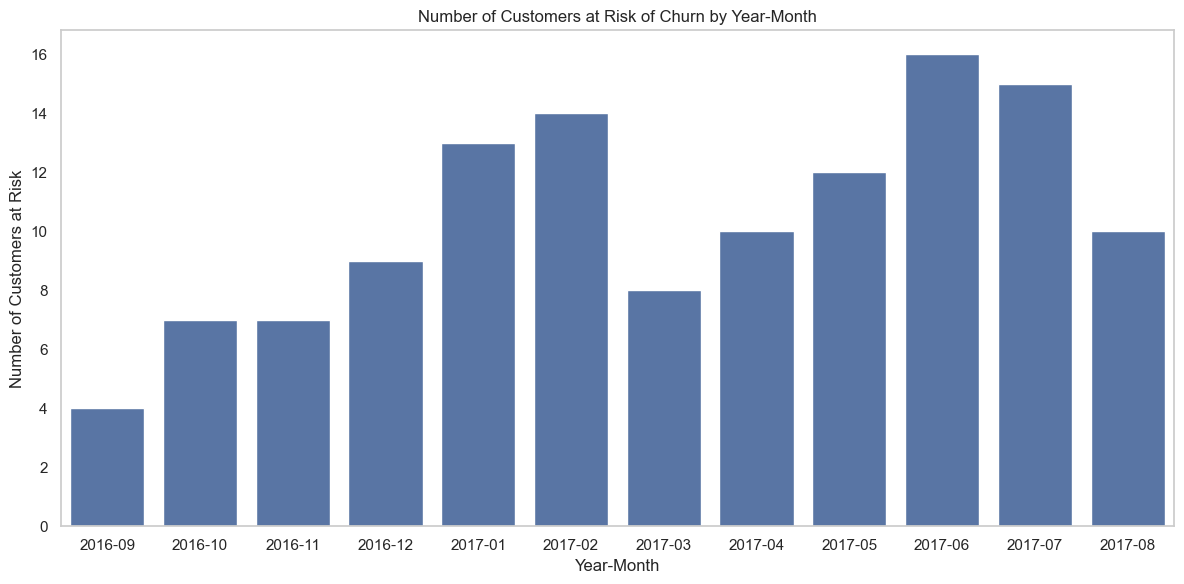

In [185]:
customers_at_risk['Date'] = pd.to_datetime(customers_at_risk['Date'])

customers_at_risk['AtRisk'] = customers_at_risk['MainMA'] <= customers_at_risk['LowerBound']

customers_at_risk['YearMonth'] = customers_at_risk['Date'].dt.to_period(
    'M').dt.strftime('%Y-%m')

at_risk_counts = customers_at_risk.groupby(
    'YearMonth')['AtRisk'].sum().reset_index()

at_risk_counts.rename(columns={'AtRisk': 'CustomersAtRisk'}, inplace=True)

plt.figure(figsize=(12, 6))
sns.barplot(data=at_risk_counts, x='YearMonth',
            y='CustomersAtRisk')
plt.title('Number of Customers at Risk of Churn by Year-Month')
plt.xlabel('Year-Month')
plt.ylabel('Number of Customers at Risk')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Channels used by Retention Risk Groups


In [60]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    )) / 90, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those with a retention risk: Less than threshold or have not purchased within the last 3 months
        RetentionRisk AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag >= lt.OneMonthMA AND lt.Date < (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                RetentionRisk
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            RetentionRisk,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df_retentionRisk = rows.to_dataframe()

In [61]:
query = f"""
        -- Compute the Number of purchases made by each visitor in a day
        -- NULL transaction means that there are no transactions made
        WITH DailyPurchases AS (
            SELECT
                PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date,
                fullVisitorID,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS DailyPurchaseCount
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
                UNNEST(hits) AS hits
            GROUP BY
                Date,
                fullVisitorID
        ),
        -- Compute the 30 Day Moving Average and the 90 Day Moving Average STD
        MovingAverages AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                COALESCE(
                    SUM(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 29 PRECEDING AND CURRENT ROW
                    )/30, 0
                ) AS OneMonthMA,
                COALESCE(
                    STDDEV(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    ) * (COUNT(DailyPurchaseCount) OVER (
                        PARTITION BY fullVisitorID
                        ORDER BY Date
                        ROWS BETWEEN 89 PRECEDING AND CURRENT ROW
                    )) / 90, 0
                ) AS ThreeMonthSTDMA
            FROM
                DailyPurchases
        ),
        -- Find the threshold at which the customer is considered at risk of retention
        Threshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                (OneMonthMA - ThreeMonthSTDMA) AS LowerBound
            FROM
                MovingAverages
        ),
        -- Lag the threshold by 30 Days and the visitor should not be considered at risk immediately
        LaggingThreshold AS (
            SELECT
                Date,
                fullVisitorID,
                DailyPurchaseCount,
                OneMonthMA,
                LowerBound,
                COALESCE(
                    LAG(LowerBound, 29) OVER (PARTITION BY fullVisitorID ORDER BY Date), 0
                ) AS LowerBoundOneMonthLag
            FROM
                Threshold
            ORDER BY
                Date
        ),
        -- Find the channels used by those without a retention risk: More than threshold or have purchased within the last 3 months
        Retention AS (
            SELECT
                channelGrouping AS Channel,
                SUM(IF(totals.transactions IS NOT NULL, totals.transactions, 0)) AS Transactions
            FROM
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` df
            RIGHT JOIN
                LaggingThreshold lt
            ON
                df.fullVisitorID = lt.fullVisitorID
            WHERE
                lt.LowerBoundOneMonthLag < lt.OneMonthMA AND lt.Date >= (SELECT MAX(Date) FROM LaggingThreshold) - INTERVAL 3 MONTH
            GROUP BY
                Channel
        ),
        TotalTransactions AS (
            SELECT
                SUM(Transactions) AS Total
            FROM
                Retention
        )

        SELECT
            Channel,
            Transactions,
            (Transactions / TotalTransactions.Total) * 100 AS Transactions_Pct
        FROM
            Retention,
            TotalTransactions
        ORDER BY
            Transactions_Pct DESC
        """

rows = client.query(query)

result_df_notRetentionRisk = rows.to_dataframe()

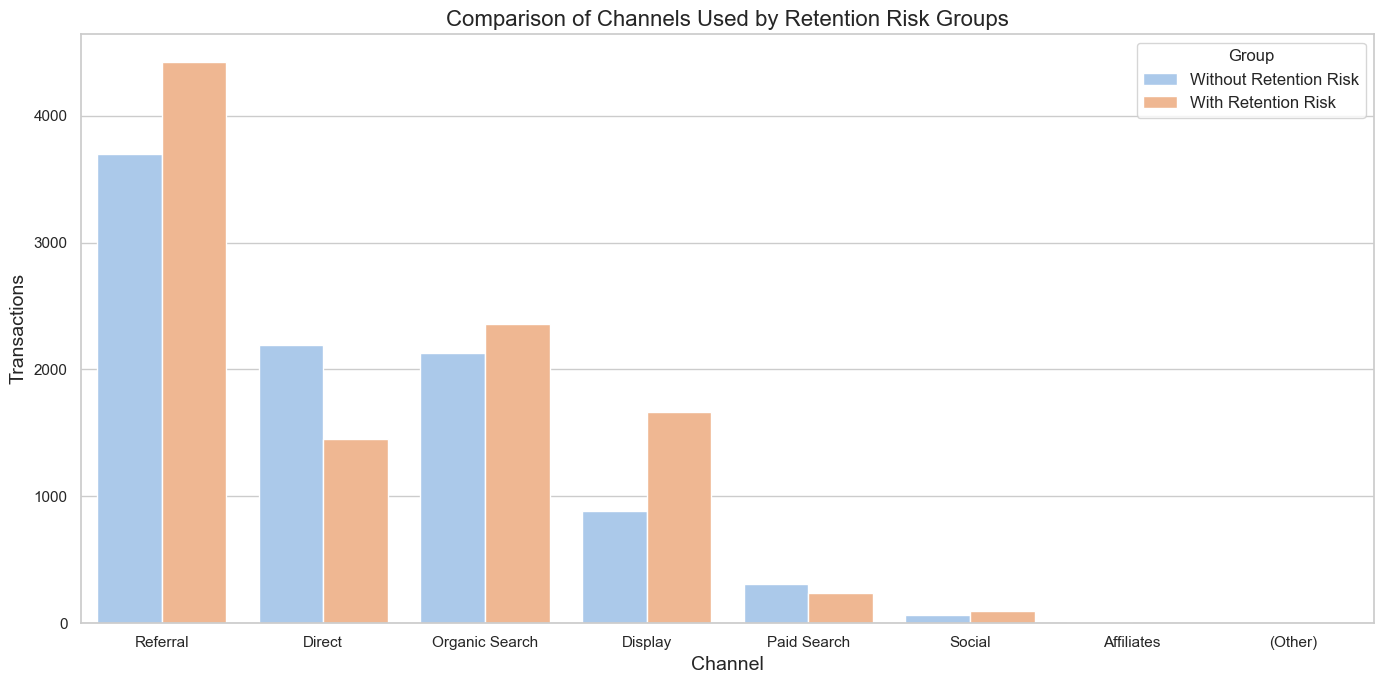

In [74]:
# Add a column to distinguish between the two groups
result_df_notRetentionRisk['Group'] = 'Without Retention Risk'
result_df_retentionRisk['Group'] = 'With Retention Risk'

combined_df = pd.concat([result_df_notRetentionRisk, result_df_retentionRisk])

plt.figure(figsize=(14, 7))
sns.barplot(x='Channel', y='Transactions', hue='Group',
            data=combined_df, palette='pastel', ci=None)

plt.title('Comparison of Channels Used by Retention Risk Groups', fontsize=16)
plt.xlabel('Channel', fontsize=14)
plt.ylabel('Transactions', fontsize=14)
plt.legend(title='Group', fontsize=12)
plt.tight_layout()

plt.show()

Given the differences in performance, targeted retention strategies could focus on leveraging referral channels more effectively and optimizing the performance of Display ads for at-risk users.

Channels like Referrals, Direct, Organic Search and Display should be prioritized in marketing efforts due to their significant contribution to user engagement.


### Evaluating current retention strategies


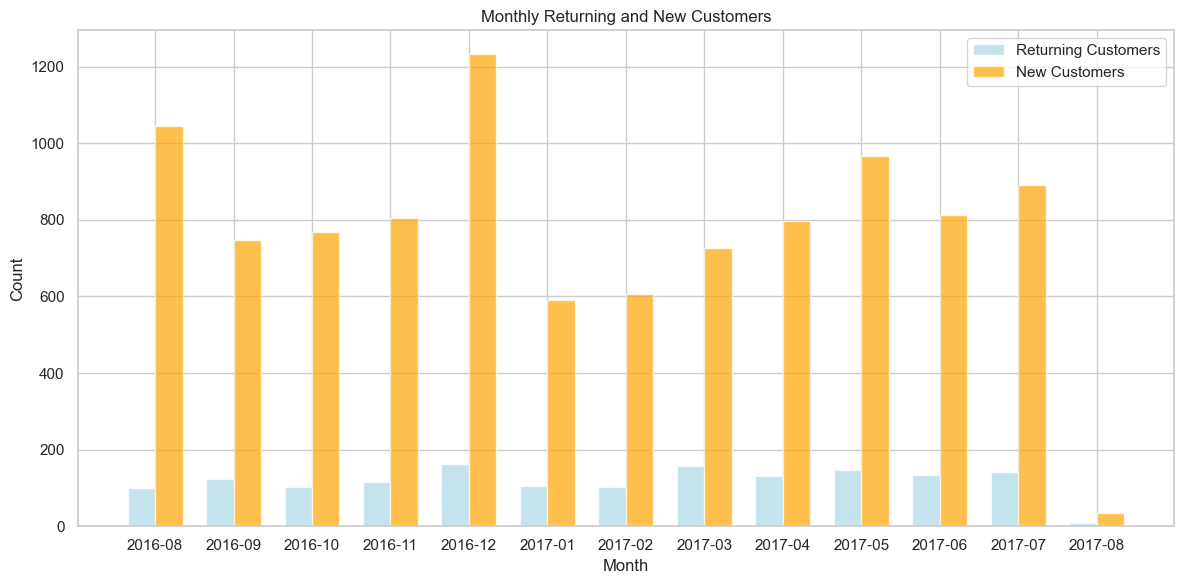

In [235]:
# https://medium.com/@busegungor2303/calculation-of-cltv-and-prediction-of-cltv-71c4f754dd90
query = f"""
        SELECT COALESCE(totals.totalTransactionRevenue, 0)/1e6 AS TotalRevenue, COALESCE(totals.transactions, 0) AS Transactions, fullVisitorId, PARSE_DATE('%Y%m%d', _TABLE_SUFFIX) AS Date
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        """

rows = client.query(query)

result_df = rows.to_dataframe()

result_df['Date'] = pd.to_datetime(result_df['Date'])

purchases = result_df.query("Transactions > 0")

purchases = purchases.sort_values('Date')

# Initialize a set to track seen visitors
seen_visitors = set()

# Function to mark new and returning customers


def classify_customers(visitor_id):
    if visitor_id in seen_visitors:
        return 'Returning'
    else:
        seen_visitors.add(visitor_id)
        return 'New'


# Apply the classification
purchases['VisitorType'] = purchases['fullVisitorId'].apply(classify_customers)

# Aggregate the data by month
monthly_summary = purchases.groupby(purchases['Date'].dt.to_period('M')).agg(
    total_transactions=('Transactions', 'count'),
    unique_visitors=('fullVisitorId', 'nunique'),
    new_customers=('VisitorType', lambda x: (x == 'New').sum()),
    returning_customers=('VisitorType', lambda x: (x == 'Returning').sum())
).reset_index()

monthly_summary['Date'] = monthly_summary['Date'].dt.to_timestamp()

plt.figure(figsize=(12, 6))

bar_width = 0.35
x = range(len(monthly_summary))

# Bar plot for unique visitors
plt.bar(x, monthly_summary['returning_customers'],
        width=bar_width, label='Returning Customers',
        color='lightblue', alpha=0.7)

# Bar plot for new customers, offset by bar_width
plt.bar([p + bar_width for p in x], monthly_summary['new_customers'],
        width=bar_width, label='New Customers',
        color='orange', alpha=0.7)

# Set x-ticks to the center of the bars
plt.xticks([p + bar_width / 2 for p in x],
           monthly_summary['Date'].dt.strftime('%Y-%m'))


plt.title('Monthly Returning and New Customers')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()

plt.show()

A large proportion of customers monthly are new, which could suggest that our marketing strategies are effectively attracting new audiences, but it also raises concerns about customer retention and the need to enhance our efforts to convert these new customers into loyal, repeat buyers.


In [232]:
# https://medium.com/@busegungor2303/calculation-of-cltv-and-prediction-of-cltv-71c4f754dd90
query = f"""
        SELECT COALESCE(totals.totalTransactionRevenue, 0)/1e6 AS TotalRevenue, COALESCE(totals.transactions) AS Transactions, fullVisitorId
        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        """

rows = client.query(query)

result_df = rows.to_dataframe()

# Only for those where transactions > 0 since we are looking at customers and not visitors
sub_df = result_df.query("Transactions > 0")
sub_df = sub_df.groupby("fullVisitorId").sum()
sub_df['AvgOrderValue'] = sub_df.TotalRevenue / sub_df.Transactions

print(sub_df.sort_values("AvgOrderValue").query("AvgOrderValue > 0"), '\n')

AvgCustomerValue = sub_df.TotalRevenue.sum() / len(sub_df)
# The average value of a customer that purchases
print("Customer value is: ", round(AvgCustomerValue, 5), '\n')

# The likelihood of a customer making a second purchase
AvgRepeatRate = len(sub_df.query("Transactions > 1")) / len(sub_df)
print("Repeat rate is: ", round(AvgRepeatRate*100, 4), '% \n')

                     TotalRevenue  Transactions  AvgOrderValue
fullVisitorId                                                 
9367883304718826385          1.20             1            1.2
3568593840277988902          3.01             2          1.505
0136876972401975041          2.04             1           2.04
3073830805992104825          2.49             1           2.49
7161524936078300347          2.50             1            2.5
...                           ...           ...            ...
7965265156545901045       4849.60             1         4849.6
5469079519715865124       5608.40             1         5608.4
1957458976293878100     128412.52            22    5836.932727
7496147812697146114       7003.50             1         7003.5
5632276788326171571      16032.75             1       16032.75

[9996 rows x 3 columns] 

Customer value is:  177.62415 

Repeat rate is:  11.6344 % 



In [18]:
# Repeat rate for valuable customers
val_sub_df = sub_df.query(f"AvgOrderValue > {AvgCustomerValue}")
val_RepeatRate = len(val_sub_df.query("Transactions > 1")) / len(val_sub_df)

print(f"The repeat rate for valuable customers is: {
      round(val_RepeatRate*100, 4)}", '% \n')

The repeat rate for valuable customers is: 24.4152 % 



Since the repeat rate for valuable customers is greater then the average (24% > 11.6%), current retention strategies are effective in retaining valuable customers to a certain extent.


### Analyse by Cohort (Customer Retention)


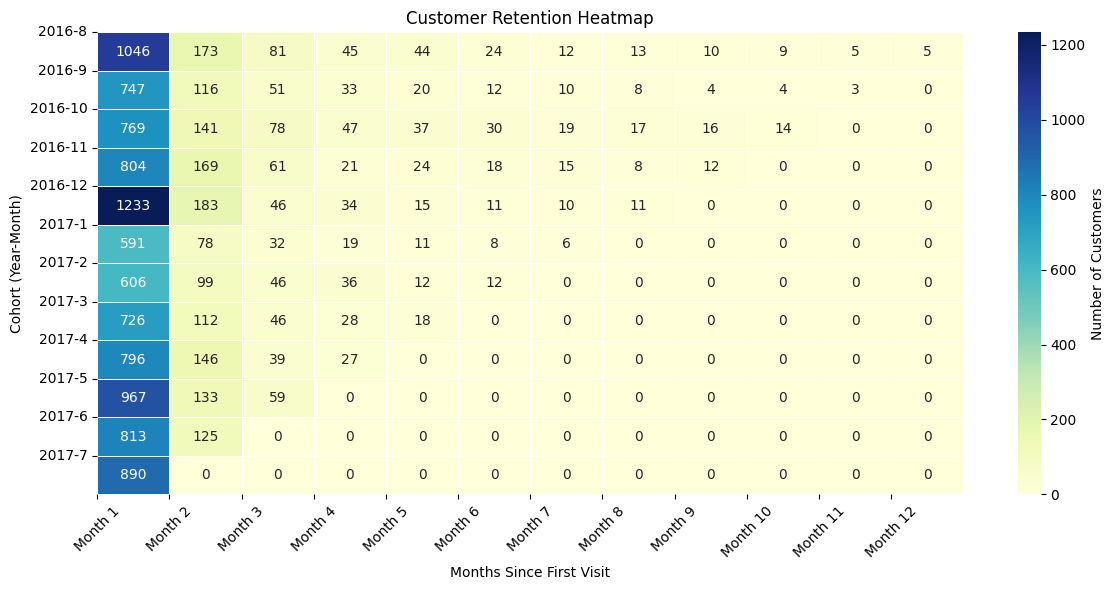

In [34]:
# https://whatfix.com/blog/retention-analysis/
# https://userpilot.com/blog/cohort-retention-analysis/#:~:text=Cohort%20retention%20analysis%20tracks%20how,useful%20for%20predicting%20future%20revenue.
# https://netcorecloud.com/blog/cohort-retention-analysis/#h-cohort-retention-analysis-explained-with-an-example
query = """
        WITH Cohorts AS (
            SELECT 
                fullVisitorID,
                PARSE_DATE('%Y%m%d', MIN(_TABLE_SUFFIX)) AS FirstVisitDate
            FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`
            WHERE 
                totals.transactions IS NOT NULL
                AND _TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
            GROUP BY 
                fullVisitorID
        ),

        CustomerRetention AS (
            SELECT
                EXTRACT(YEAR FROM c.FirstVisitDate) AS CohortYear,
                EXTRACT(MONTH FROM c.FirstVisitDate) AS CohortMonth,
                COUNT(DISTINCT c.fullVisitorID) AS NumOfCustomers,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 0 THEN s.fullVisitorID END) AS Month1,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 1 THEN s.fullVisitorID END) AS Month2,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 2 THEN s.fullVisitorID END) AS Month3,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 3 THEN s.fullVisitorID END) AS Month4,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 4 THEN s.fullVisitorID END) AS Month5,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 5 THEN s.fullVisitorID END) AS Month6,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 6 THEN s.fullVisitorID END) AS Month7,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 7 THEN s.fullVisitorID END) AS Month8,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 8 THEN s.fullVisitorID END) AS Month9,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 9 THEN s.fullVisitorID END) AS Month10,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 10 THEN s.fullVisitorID END) AS Month11,
                COUNT(DISTINCT CASE WHEN DATE_DIFF(PARSE_DATE('%Y%m%d', s._TABLE_SUFFIX), c.FirstVisitDate, MONTH) = 11 THEN s.fullVisitorID END) AS Month12
            FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*` s
            JOIN 
                Cohorts c
            ON 
                s.fullVisitorID = c.fullVisitorID
            WHERE
                s._TABLE_SUFFIX BETWEEN '20160801' AND '20170731'
            GROUP BY 
                CohortYear, CohortMonth
        )

        SELECT 
            CohortYear, CohortMonth, NumOfCustomers, Month1, Month2, Month3, Month4, Month5, Month6, Month7, Month8, Month9, Month10, Month11, Month12
        FROM 
            CustomerRetention
        ORDER BY
            CohortYear ASC, CohortMonth ASC;
        """

df = client.query(query).to_dataframe().astype('int64')

df.set_index(['CohortYear', 'CohortMonth'], inplace=True)
heatmap_data = df[['Month1', 'Month2', 'Month3', 'Month4', 'Month5',
                   'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12']]

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlGnBu',
            cbar_kws={'label': 'Number of Customers'}, linewidths=.5)
plt.title('Customer Retention Heatmap')
plt.xlabel('Months Since First Visit')
plt.ylabel('Cohort (Year-Month)')
plt.xticks(ticks=range(12), labels=[
           f'Month {i+1}' for i in range(12)], rotation=45)
plt.yticks(ticks=range(len(heatmap_data.index)), labels=[
           f"{year}-{month}" for year, month in heatmap_data.index], rotation=0)
plt.tight_layout()
plt.show()

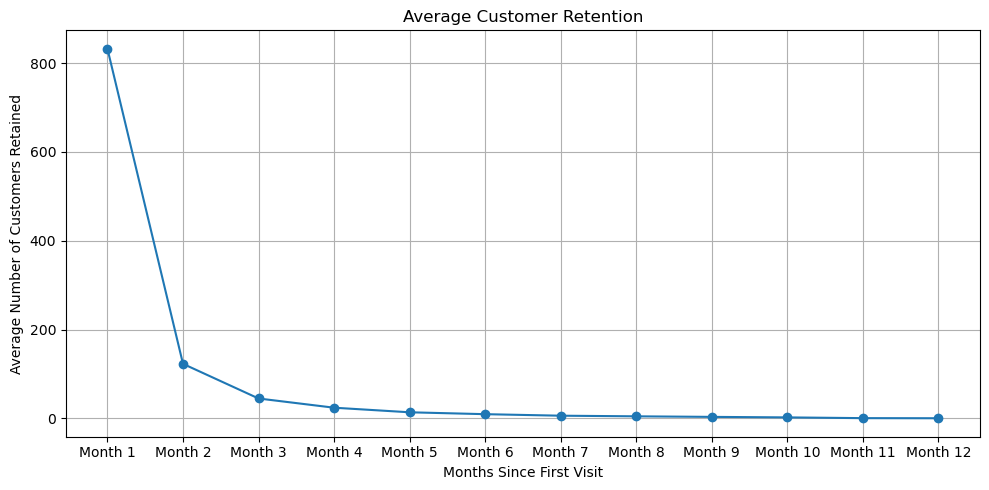

In [3]:
average_retention = df[['Month1', 'Month2', 'Month3', 'Month4', 'Month5',
                        'Month6', 'Month7', 'Month8', 'Month9', 'Month10', 'Month11', 'Month12']].mean()
average_retention_df = pd.DataFrame(average_retention).reset_index()
average_retention_df.columns = ['Month', 'AverageRetention']
average_retention_df['Month'] = average_retention_df['Month'].str.replace(
    'Month', '').astype(int)

plt.figure(figsize=(10, 5))
plt.plot(average_retention_df['Month'],
         average_retention_df['AverageRetention'], marker='o')
plt.title('Average Customer Retention')
plt.xlabel('Months Since First Visit')
plt.ylabel('Average Number of Customers Retained')
plt.xticks(ticks=range(1, 13), labels=[f'Month {i}' for i in range(1, 13)])
plt.grid()
plt.tight_layout()
plt.show()

- Cohort data shows a sharp drop-off in retention month-over-month. For example, in the cohort of August 2016, only 173 of the original 1,046 customers (16.54%) returned by the second month, and retention continued to decline steeply thereafter. This pattern repeats across cohorts, with low month-over-month retention rates.
- Larger cohorts (e.g. December 2016 with 1,233 customers) do not necessarily result in higher retention, as retention rates remain relatively similar regardless of initial cohort size. This implies that the initial engagement strategies might not be effective in fostering long-term loyalty.


#### Conclusion for evaluating customer retention strategies

Current retention strategies are not highly effective, as indicated by the low repeat rate (11.63%) and steep monthly drop-offs in cohort retention. While high-value customers show better loyalty with a repeat rate of 24.41%, the majority of customers do not return for subsequent purchases. This suggests a need for targeted retention efforts, particularly focused on maintaining engagement and increasing the lifetime value of each customer segment.


# Q3


What are the most effective marketing channels and campaigns?

- Evaluate the ROI of different marketing channels.

- Analyze the impact of various promotional campaigns on sales


### Evalutaing revenue of different marketing channels


1. **Organic Search**: Traffic that comes from search engines like Google or Bing when users find your website through unpaid search results. It’s driven by SEO efforts to optimize website content and improve rankings.

2. **Referral**: Visitors who come to your site from links on other websites. This can include links from blogs, forums, or other online platforms that lead users to your content.

3. **Direct**: Traffic from users who type your website URL directly into their browser or have it bookmarked. This indicates brand awareness and loyalty, as these users are actively seeking your site.

4. **Paid Search**: Traffic generated from paid advertising on search engines (like Google Ads). Advertisers bid on keywords to have their ads appear in search results, driving targeted traffic to their websites.

5. **Social**: Visitors who arrive at your site from social media platforms like Facebook, Twitter, Instagram, or LinkedIn. This includes both organic posts and paid advertisements on these platforms.

6. **Display**: Traffic generated from display advertising, which includes banner ads, video ads, and other visual ads placed on websites across the internet. These ads are typically targeted based on user behavior and interests.

7. **Affiliates**: Traffic that comes from affiliate marketing, where other websites or influencers promote your products or services in exchange for a commission on sales generated through their referrals.


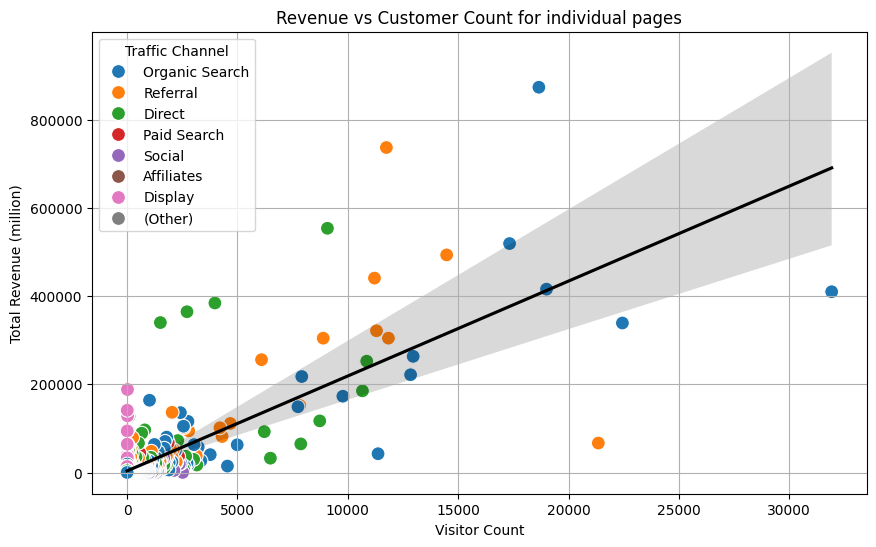

In [41]:
# For each page title, find the number of customers and how they are searching their products and purchasing them
query = f"""
        SELECT
            IF(LENGTH(hits.page.pageTitle) <= 20, hits.page.pageTitle, CONCAT(SUBSTR(hits.page.pageTitle, 1, 20), '...')) AS PageTitle,
            channelGrouping AS Channel,
            COUNT(fullVisitorID) AS VisitorCount,
            SUM(IF(totals.transactions IS NULL, 0, totals.transactions)) AS TransactionCount,
            SUM(totals.totalTransactionRevenue/1e6) AS TotalRevenue
        FROM
            `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits
        WHERE hits.page.pageTitle NOT LIKE '%Checkout%'
            AND hits.page.pageTitle NOT LIKE '%Home%'
            AND hits.page.pageTitle NOT LIKE '%Cart%'
            AND hits.page.pageTitle NOT LIKE '%Google%'
            AND hits.page.pageTitle NOT LIKE '%Payment%'
            AND hits.page.pageTitle NOT LIKE '%results%'
        GROUP BY PageTitle, Channel
        ORDER BY VisitorCount DESC
        """

rows = client.query(query)

result_df = rows.to_dataframe()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=result_df, x='VisitorCount',
                y='TotalRevenue', hue='Channel', s=100)
sns.regplot(data=result_df, x='VisitorCount', y='TotalRevenue',
            scatter=False, color='black', line_kws={"label": "Best Fit Line"})

plt.title('Revenue vs Customer Count for individual pages')
plt.xlabel('Visitor Count')
plt.ylabel('Total Revenue (million)')
plt.legend(title='Traffic Channel')
plt.grid(True)
plt.show()

Referral and organic search channels are the most effective traffic sources in terms of generating revenue relative to visitor count. Most of the pages have a generate more revenue relative to visitor count.

Direct channels are also effeective to a certain extent, as they can attract visitors to their pages while generating a substantial revenue.

Although the display channel generates one of the lowest visitor counts, it is also produces a significant revenue. In this case, the display channel should be improved to enhance visitor count and potentially generate greater revenue.


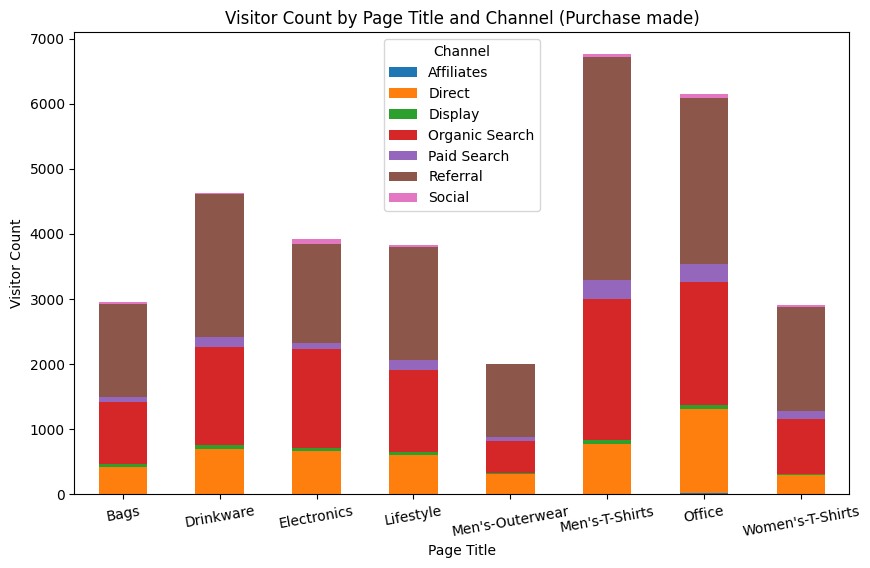

In [55]:
topSevenPageTitles = result_df.drop(columns=['Channel']).groupby("PageTitle").sum().sort_values(
    "VisitorCount", ascending=False).head(8).query("PageTitle != 'Page Unavailable'").index
plot_df = result_df.query("PageTitle in @topSevenPageTitles")


grouped_df = plot_df.groupby(['PageTitle', 'Channel'])[
    'VisitorCount'].sum().unstack(fill_value=0)

grouped_df.plot(kind='bar', stacked=True, figsize=(10, 6))

plt.xlabel('Page Title')
plt.ylabel('Visitor Count')
plt.title('Visitor Count by Page Title and Channel (Purchase made)')
plt.legend(title='Channel')
plt.xticks(rotation=10)

plt.show()

For the top seven most popular categories, the referral channel emerges as the leading channel of purchases. This indicates that business should prioritize promoting its products through referral channels over other marketing channels.


### Promotional campaigns (Ads)


In [24]:
query = """
        SELECT  
                trafficSource.adContent AS AdContent,
                trafficSource.adwordsClickInfo.page AS AdPage, 
                trafficSource.adwordsClickInfo.slot AS AdPosition, 
                SUM(COALESCE(totals.transactions, 0)) AS TotalTransactions, 
                SUM(totals.hits) AS Hits
        FROM 
                `bigquery-public-data.google_analytics_sample.ga_sessions_*`
        GROUP BY AdContent, AdPage, AdPosition
        ORDER BY TotalTransactions DESC
        LIMIT 20
        """

rows = client.query(query)

result_df = rows.to_dataframe()

sub_df = result_df.query(
    "AdPosition.isna() | ~AdPosition.isna()")
sub_df["AdPage"] = sub_df["AdPage"].notna()
sub_df["AdPosition"] = sub_df["AdPosition"].notna()

sub_df = sub_df.groupby(["AdPage", "AdPosition"])[
    ["TotalTransactions", "Hits"]].sum().reset_index()
sub_df['TransactionRate'] = sub_df.TotalTransactions / sub_df.Hits

print(sub_df, '\n')
print("Likelihood of purchase after viewing an Ad is: ",
      round((sub_df.at[1, "TransactionRate"] - sub_df.at[0, "TransactionRate"]) / sub_df.at[0, "TransactionRate"]*100, 4),  "%", " greater than when no Ad is viewed.")

   AdPage  AdPosition  TotalTransactions     Hits  TransactionRate
0   False       False              11650  3999228         0.002913
1    True        True                465   150753         0.003085 

Likelihood of purchase after viewing an Ad is:  5.8857 %  greater than when no Ad is viewed.


Although the transaction rate is higher when an ad is viewed compared to when it is not, we need to evaluate whether the cost of placing the ad outweighs its economic benefits.


### Promotional Discounts


To analyze the different promotional campaigns, we examine the daily price fluctuations and compare them with the average price of each product over a one-year period. This helps us determine the daily discounts available to customers. We increment the discount rate to assess its impact on transactional revenue, allowing us to evaluate the effectiveness of the discounts.


In [149]:
query = """
        SELECT 
            FORMAT_DATE('%Y-%m-%d', PARSE_DATE('%Y%m%d', _TABLE_SUFFIX)) AS date,
            product.v2ProductName AS product_name,
            totals.transactions AS transactions,
            totals.totalTransactionRevenue/1e6 AS revenue,
            product.localProductPrice/1e6 AS price,
            product.productQuantity AS quantity

        FROM `bigquery-public-data.google_analytics_sample.ga_sessions_*`, UNNEST(hits) AS hits, UNNEST(hits.product) AS product
        WHERE totals.totalTransactionRevenue > 0
        ORDER BY date, product_name
        """

rows = client.query(query)

result_df = rows.to_dataframe()

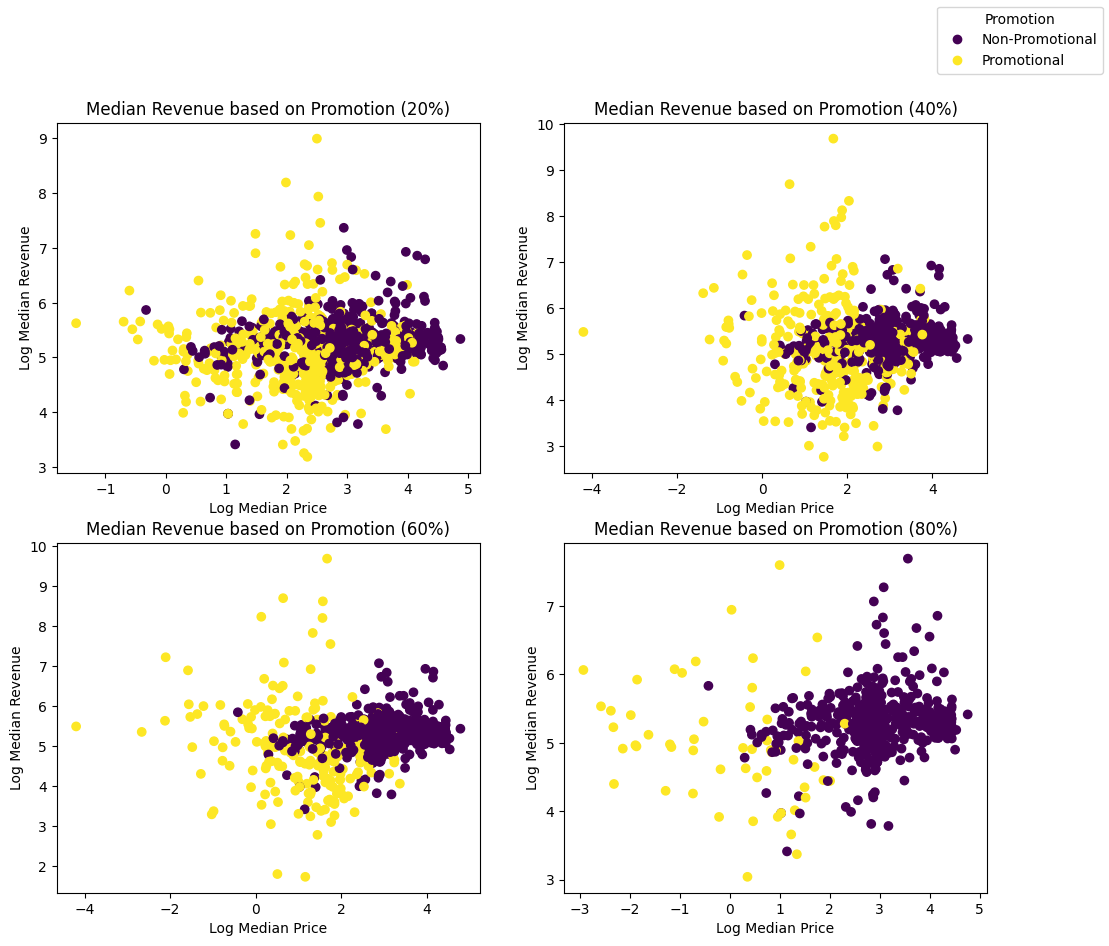

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

In [117]:
test_df = result_df

test_df = test_df.groupby(
    by=["product_name", "date"])["price"].median().reset_index()

product_info = test_df.groupby(by=["product_name"]).median("price").reset_index()
product_info = product_info.set_index("product_name")

product_info = product_info["price"]
test_df["promotion"] = False


def discount(row, rate):
    if row["price"] < (1 - rate/100) * product_info.loc[row["product_name"]]:
        return True
    else:
        return False


fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i in range(1, 5):
    test_df["promotion"] = test_df.apply(discount, axis=1, args=(i * 20,))

    df = (test_df.groupby(["product_name", "promotion"]).sum(
        "revenue")/test_df.groupby(["product_name", "promotion"]).count()).reset_index()
    df["log_price"] = np.log(
        df["price"])
    df["log_revenue"] = np.log(
        df["revenue"])

    # Create a new figure for each scatter plot
    plt.figure(figsize=(4, 4))

    # Create scatter plot
    scatter = axes[i - 1].scatter(
        x=df["log_price"],
        y=df["log_revenue"],
        c=df["promotion"].astype(
            'category').cat.codes,  # Convert promotion to numeric for coloring
        cmap='viridis'  # Colormap for different promotion categories
    )

    # Add title and labels
    axes[i - 1].set_title(f"Median Revenue based on Promotion ({i * 20}%)")
    axes[i - 1].set_xlabel("Log Median Price")
    axes[i - 1].set_ylabel("Log Median Revenue")

handles, labels = scatter.legend_elements()
fig.legend(handles, ["Non-Promotional", "Promotional"],
           title="Promotion", loc='upper right')
plt.tight_layout()
plt.show()

#### Key Obeservation

- Across all discount levels, revenue generally increases as price increases albeit with high variability. This shows a weak positive correlation between price and revenue
- Higher promotions concentrate the non-promotional variability but the promotional prices seem to continue have high variance
- At 40% discount, the overall revenue of promotional products is higher than non-promotional products. 40% discount might be close to the ideal balance between lower prices and higher revenue
- In conclusion, the discount in prices does not seem to have a major impact on the total revenue from the transactions. This might be becasue of poor marketing of the discount or the increase in demand for the products is outweight by the lower prices.

To get a clearer picture of the data, we can look at the revenue changes to determine if it is a smart financial decision to offer discounts to users

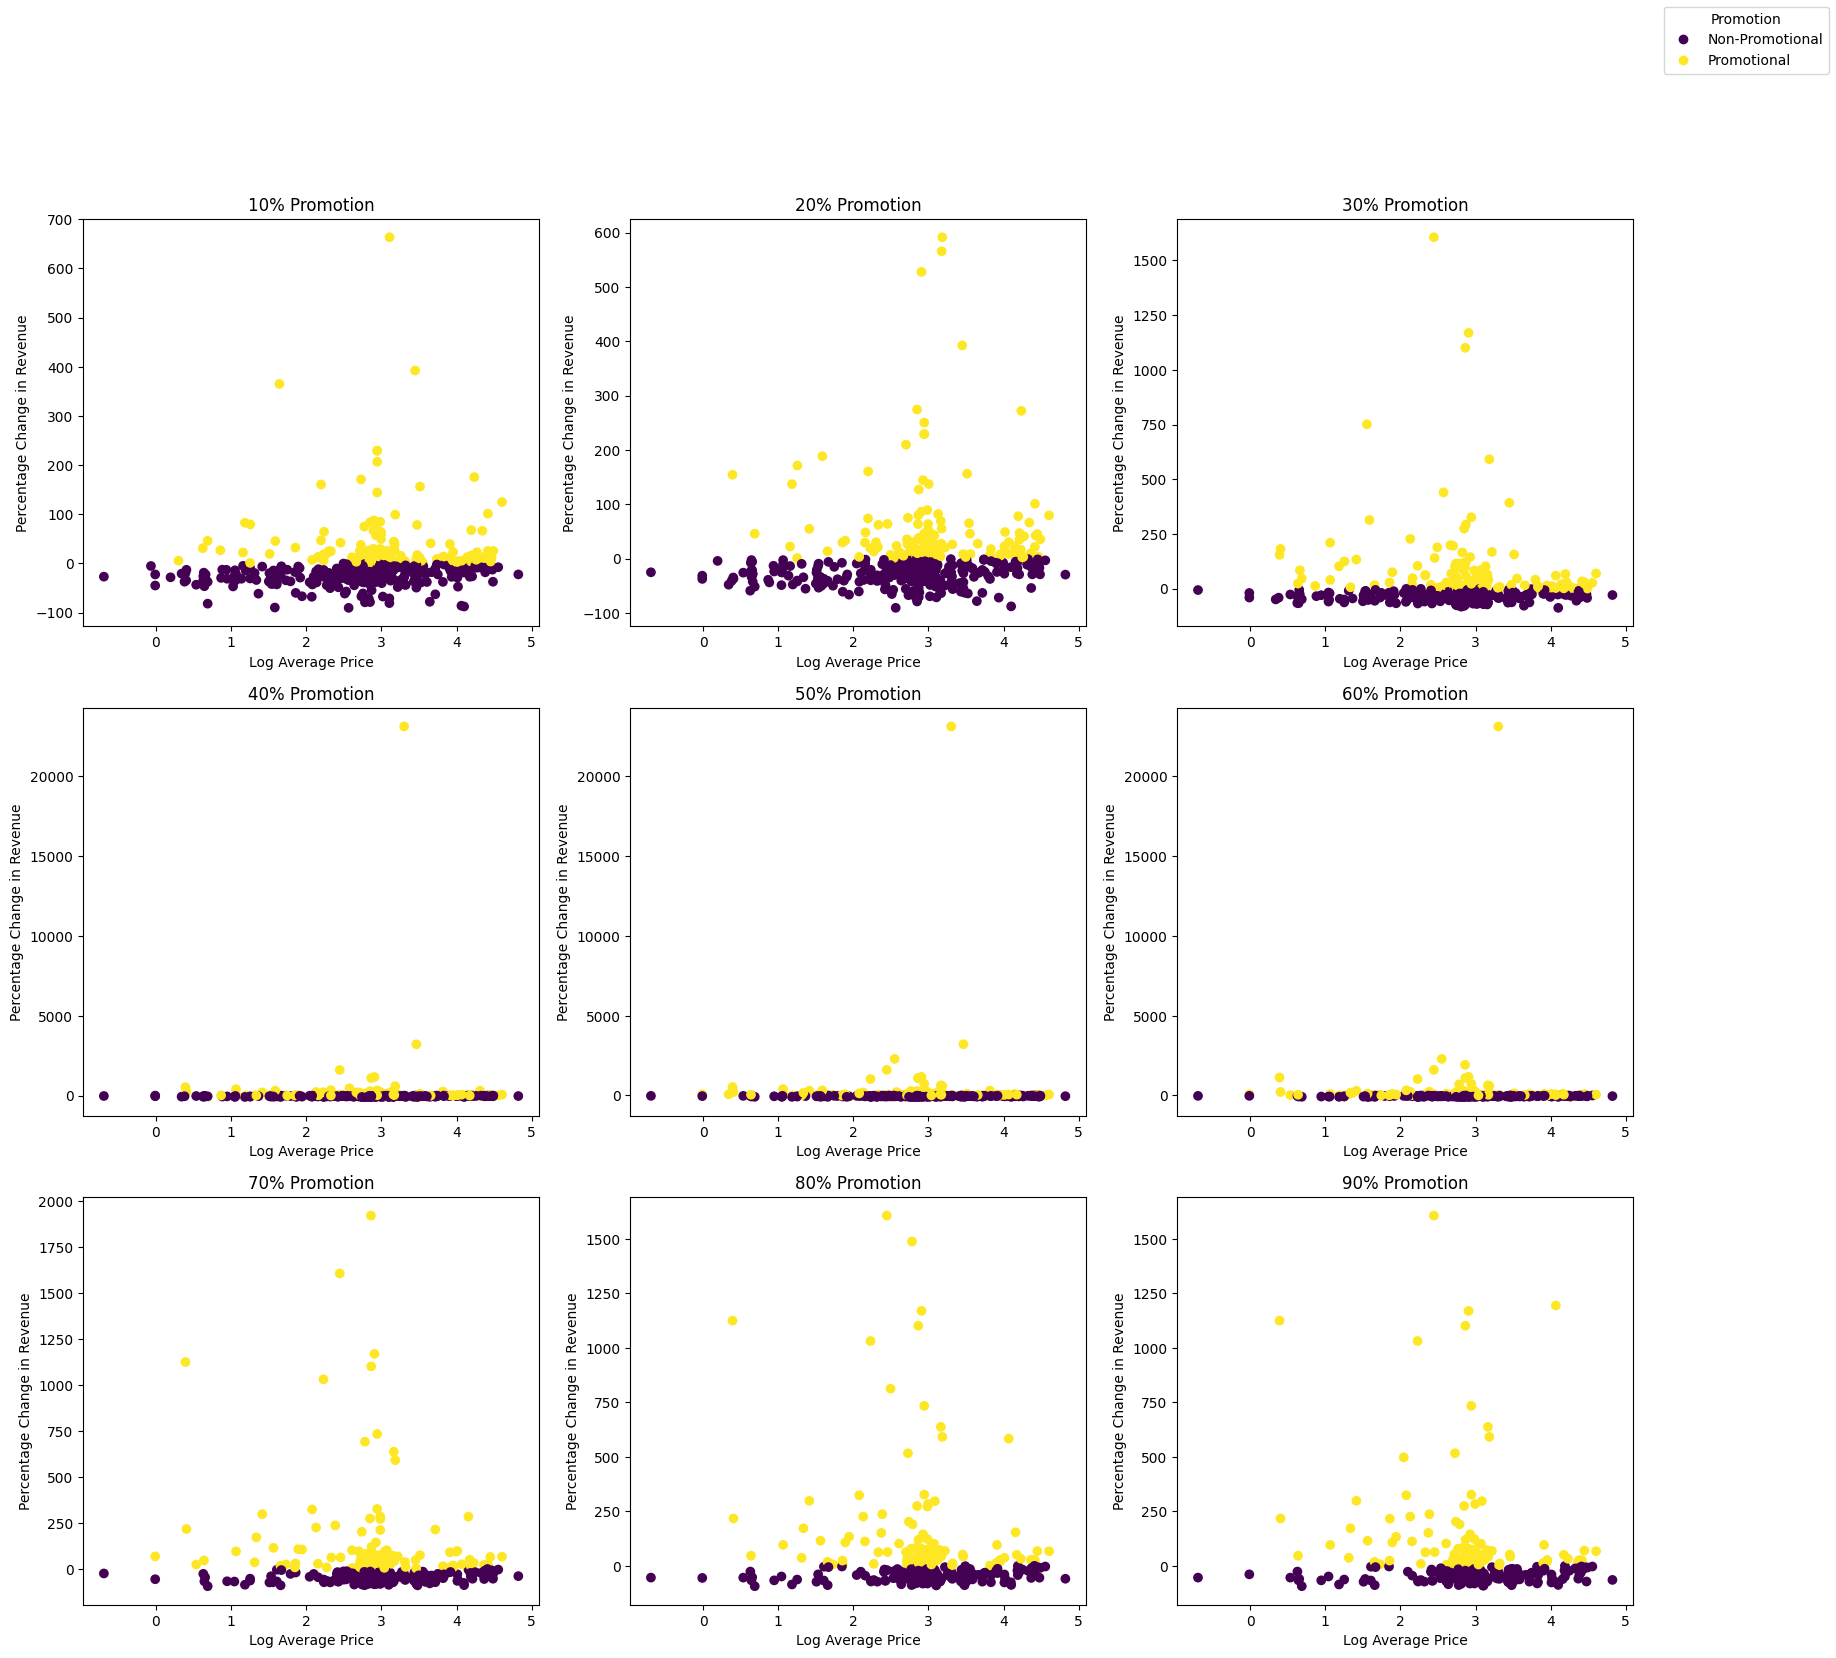

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

   discount_rate  num_profits  num_losses  percentage_profit
0             10          155         337           0.315041
1             20          142         323           0.305376
2             30          144         287           0.334107
3             40          126         272           0.316583
4             50          109         251           0.302778
5             60          108         227           0.322388
6             70          105         194           0.351171
7             80           99         173           0.363971
8             90           93         169           0.354962


In [150]:
product_info = test_df.groupby("product_name")["price"].median().reset_index()
product_price = product_info.set_index("product_name")["price"]

test_df["promotion"] = False

discount_data = []

def discount(row, rate):
    if row["price"] < (1 - rate/100) * product_price.loc[row["product_name"]]:
        return True
    else:
        return False


fig, axes = plt.subplots(3, 3, figsize=(20, 18))
axes = axes.flatten()

for i in range(1, 10):
    test_df["promotion"] = test_df.apply(discount, axis=1, args=(i * 10,))

    average_revenue_per_product = test_df.groupby(["product_name", "promotion"]).agg({"price": "median", "revenue": "median"}).reset_index()
    duplicated_product = average_revenue_per_product[average_revenue_per_product["product_name"].duplicated()]["product_name"].tolist()
    average_revenue_per_product = average_revenue_per_product[average_revenue_per_product["product_name"].isin(duplicated_product)]
    average_revenue_per_product = average_revenue_per_product.pivot(values = ["price", "revenue"], index = ["product_name"], columns = ["promotion"]).reset_index()
    average_revenue_per_product["revenue change"] = (average_revenue_per_product["revenue"][True] - average_revenue_per_product["revenue"][False])/average_revenue_per_product["revenue"][False] * 100
    average_revenue_per_product["median_price"] = average_revenue_per_product["product_name"].map(product_price)
    average_revenue_per_product["profit"] = average_revenue_per_product["revenue change"] > 0
    average_revenue_per_product["log_median_price"] = np.log(
        average_revenue_per_product["median_price"])
    num_profits = sum(average_revenue_per_product["profit"])
    num_losses = len(average_revenue_per_product) - num_profits
    discount_data.append({
        "discount_rate": i * 10,
        "num_profits": num_profits,
        "num_losses": num_losses,
        "percentage_profit": num_profits/(num_profits + num_losses)
    })
    # Create a new figure for each scatter plot
    plt.figure(figsize=(4, 4))

    # Create scatter plot
    scatter = axes[i - 1].scatter(
        x=average_revenue_per_product["log_median_price"],
        y=average_revenue_per_product["revenue change"],
        c=average_revenue_per_product["profit"].astype(
            'category').cat.codes,  # Convert promotion to numeric for coloring
        cmap='viridis'  # Colormap for different promotion categories
    )

    # Add title and labels
    axes[i - 1].set_title(f"{i * 10}% Promotion")
    axes[i - 1].set_xlabel("Log Average Price")
    axes[i - 1].set_ylabel("Percentage Change in Revenue")

handles, labels = scatter.legend_elements()
fig.legend(handles, ["Non-Promotional", "Promotional"],
           title="Promotion", loc='upper right')

discount_df = pd.DataFrame(discount_data)
plt.tight_layout()
plt.show()

print(discount_df)

From the graph and table, we can see that offering discounts to users generally results in the lost. However, suprisingly the number of products that became profitable increases with the amount of discount given. This potentially shows that offering high discounts results in the increase in the proportion of transactions to the website outweighing the loss incurred from the lower prices. As such, for companies that aim to increase public awareness of their products, they should offer significant discount to entice greater public interest. Companies should also understand that loses are expected when offering discounts and should have the financial ability to abosrb these loses.